# What you need to know to become a data scientist?
#### - Data mining from Stack Overflow 2019 Annual Developer Survey.

* [1. Introduction](#1)
* [2. Data preparation](#2)
* [3. Q1: What skill and education background data scientists have?](#3)
   + [3.1 Data scientist comparing to other developer](#3.1)
   + [3.2 Skills](#3.2)
   + [3.3 Education](#3.3)
* [4. Q2: What salary does data scientist earn comparing to other developer?](#4)
   + [4.1 Age](#4.1)   
   + [4.2 Salary](#4.2)   
   + [4.3 Predict US Salary](#4.3)   
* [5. Q3: What features make data scientist distnct in this survey?](#5)



<a class="anchor" id="1"></a>
## 1. Introduction

The Stack Overflow Annual Developer Survey contains nearly 90000 responses fielded from over 170 countries and dependent territories. The survey examines all aspects of the developer experience from career satisfaction and job search to education and opinions on open source software. In this project, I will explore this survey dataset, specially focused on mining the people who identify themself as a data scientist. Data scientist is a very popular job since 2010s. A data scientist job openning will attract hundreds of applicants to submit their resume, I am interested what you should have to become a data scientist, also the key terms that you should add into your resume so you can increase the chance to get a data science job. The project attempt to give answers to the following three questions:

What skill and education background data scientist has?

What salary does data scientist earn comparing to other developer?

What features make data scientist distnct in this survey?

<a class="anchor" id="2"></a>
## 2. Data preparation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import networkx as nx
import random
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve,precision_recall_curve,auc,average_precision_score,accuracy_score
%matplotlib inline

print(os.listdir("../input"))

pd.set_option("max_colwidth",1000000)
pd.set_option('max_columns', 15000)

['developer_survey_2019']


In [2]:
# Read dataset
survey_2019 = pd.read_csv(r'../input/developer_survey_2019/survey_results_public.csv')
schema = pd.read_csv(r'../input/developer_survey_2019/survey_results_schema.csv')

Take a look the dimension of the dataset

In [3]:
survey_2019.shape

(88883, 85)

Check columns without missing value. Just see 3 columns without missing values.

In [4]:
survey_2019.columns[survey_2019.isnull().mean()==0]

Index(['Respondent', 'Hobbyist', 'OpenSourcer'], dtype='object')

Check the columns that have highest percentage of missing values. The BlockchainOrg has most missing values, but still less than 50%.

In [5]:
survey_2019.isnull().mean().sort_values(ascending=False)

BlockchainOrg         0.457995
CodeRevHrs            0.439825
ConvertedComp         0.371950
CompTotal             0.370577
MiscTechWorkedWith    0.329613
                        ...   
MainBranch            0.006210
Country               0.001485
OpenSourcer           0.000000
Hobbyist              0.000000
Respondent            0.000000
Length: 85, dtype: float64

<a class="anchor" id="3"></a>
## 3. Q1: What skill and education background data scientists have?


<a class="anchor" id="3.1"></a>
### 3.1 Data scientist comparing to other developer

In order to subset the data scientist people. Let's look at the DevType column which describes the role of each developer. The majority of people are "full-stack developer", they were allowed to select multiple roles so that I can anticipate data scientist can be a single role or a mixed data scientist who also know other skills.

In [6]:
# List all possible role
survey_2019['DevType'].value_counts(dropna=False)

Developer, full-stack                                                                                                                                                                                                                                                                                   8433
NaN                                                                                                                                                                                                                                                                                                     7548
Developer, back-end                                                                                                                                                                                                                                                                                     4913
Developer, back-end;Developer, front-end;Developer, full-stack                                   

I am curious that some roles might be similar to each other, for instance, full-stack developer usually means a developer can do both front-end and back-end, data scientist usually works with data analyst and data engineer. Let's transform DevType into multiple columns of which each column represent an individual roles.

In [7]:
# Missing DevType
np.sum(survey_2019['DevType'].isnull())

7548

In [8]:
# The transpose data set should have 88883-7548=81335 observations.
df = pd.get_dummies(survey_2019['DevType'].str.split(';', expand=True)
   .stack()
   ).sum(level=0)
df.shape

(81335, 24)

In [9]:
df.head()

Academic researcher  Data or business analyst  \
1                    0                         0   
2                    0                         0   
3                    0                         0   
4                    1                         0   
5                    0                         1   

   Data scientist or machine learning specialist  Database administrator  \
1                                              0                       0   
2                                              0                       0   
3                                              0                       0   
4                                              0                       0   
5                                              1                       1   

   Designer  DevOps specialist  Developer, QA or test  Developer, back-end  \
1         0                  0                      0                    0   
2         1                  0                      0                    1   
3         0                  0                      0                    0   
4         0                  0                      0                    0   
5         0                  0                      0                    0   

   Developer, desktop or enterprise applications  \
1                                              1   
2                                              0   
3                                              0   
4                                              1   
5                                              0   

   Developer, embedded applications or devices  Developer, front-end  \
1                                            0                     1   
2                                            0                     1   
3                                            0                     0   
4                                            0                     0   
5                                            0                     0   

   Developer, full-stack  Developer, game or graphics  Developer, mobile  \
1                      0                            0                  0   
2                      1                            0                  0   
3                      1                            0                  0   
4                      1                            0                  1   
5                      0                            0                  0   

   Educator  Engineer, data  Engineer, site reliability  Engineering manager  \
1         0               0                           0                    0   
2         0               0                           0                    0   
3         0               0                           0                    0   
4         0               0                           0                    0   
5         0               1                           0                    0   

   Marketing or sales professional  Product manager  Scientist  \
1                                0                0          0   
2                                0                0          0   
3                                0                0          0   
4                                0                0          0   
5                                0                0          0   

   Senior executive/VP  Student  System administrator  
1                    0        0                     0  
2                    0        0                     0  
3                    0        0                     0  
4                    0        0                     0  
5                    0        0                     0

The transformed data set looks good. Now we can generate a graph indicating the correlation among different roles. i use seaborn package to plot this correlation. 

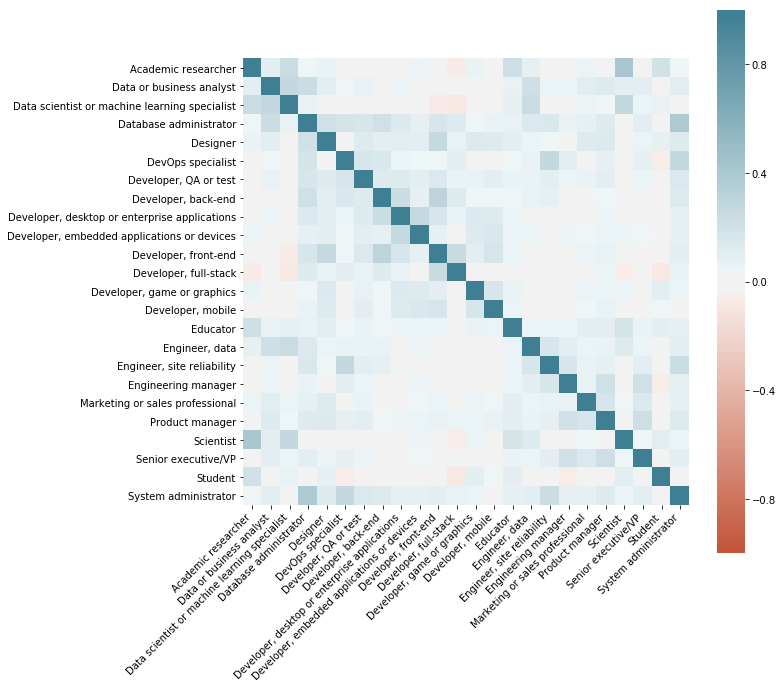

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax = sns.heatmap(df.corr(),vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

The graph shows data scientist or machine learning specialist is highly correlated with data or business analyst, data engineer and I missed one, the researcher and scientist also needs data science to do research. The interesting thing is data scientist has negative correlation with front-end and full-stack developer. That means, data scientist would rather work as back-end, but would not play a role as front-end? Let's see how many samples support this view.

In [11]:
# Counter the number of developer who is a data scientist and a front-end or full-stack developer
num1 = survey_2019[survey_2019['DevType'].str.contains("Data scientist",na = False)
           & (survey_2019['DevType'].str.contains("front-end",na = False)
           | survey_2019['DevType'].str.contains("full-stack",na = False))].shape[0]
# Counter the number of developer who is a data scientist
num2 = survey_2019[survey_2019['DevType'].str.contains("Data scientist",na = False)].shape[0]
num1/num2

0.42229102167182664

In [12]:
# Count the number of developer who is a front-end or full-stack developer
survey_2019[survey_2019['DevType'].str.contains("front-end",na = False)
           | survey_2019['DevType'].str.contains("full-stack",na = False)].shape[0]

50185

Now we see that only 42% of the data scientist is also working as a front-end or full-stack developer.

<a class="anchor" id="3.2"></a>
### 3.2 Skills

To compare the different skills between data scientist and non data scientist, I would like to divide the developer into 3 groups:

1. non data scientist - who does not identify himself as a data scientist
2. mixed data scientist - who is a data scientist as well as other role
3. pure data scientist - who has only one data scientist role

I assume these 3 groups of people have diverse skill distribution, then we know what skill make data scientist different. 

In [13]:
# Divide the data set into 3 subset and check the number of record for each group
non_data_scientist = survey_2019[~survey_2019['DevType'].str.contains("Data scientist",na = False)]
mixed_data_scientist = survey_2019[survey_2019['DevType'].str.contains("Data scientist",na = False)
                                  & (survey_2019['DevType']!='Data scientist or machine learning specialist')]
pure_data_scientist = survey_2019[survey_2019['DevType']=='Data scientist or machine learning specialist']
print(non_data_scientist.shape[0])
print(mixed_data_scientist.shape[0])
print(pure_data_scientist.shape[0])

82423
5934
526


In [14]:
# Define a function to show the top feature for each group.
def total_count(df, col1):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    
    OUTPUT:
    new_df - a dataframe shows the percentage account for the total observation. 
    '''
    new_df = df[col1].str.split(';', expand=True).stack().value_counts(dropna=False).reset_index()
    new_df.rename(columns={0: 'count'}, inplace=True)
    new_df['percentage'] = new_df['count']/np.sum(df[col1].notnull())
    return new_df
    

First, we check the LanguageWorkedWith, see what programming language the developer is using.

In [15]:
total_count(non_data_scientist,'LanguageWorkedWith')

index  count  percentage
0              JavaScript  55900    0.688627
1                HTML/CSS  52208    0.643146
2                     SQL  43769    0.539186
3                    Java  33464    0.412240
4                  Python  31318    0.385804
5   Bash/Shell/PowerShell  29117    0.358690
6                      C#  25634    0.315783
7                     PHP  21832    0.268946
8                     C++  18458    0.227382
9              TypeScript  17667    0.217638
10                      C  16343    0.201328
11              Other(s):   7238    0.089164
12                   Ruby   6905    0.085062
13                     Go   6638    0.081773
14                  Swift   5417    0.066732
15                 Kotlin   5316    0.065487
16               Assembly   5268    0.064896
17                    VBA   4291    0.052860
18            Objective-C   3937    0.048500
19                      R   3073    0.037856
20                  Scala   2698    0.033236
21                   Rust   2557    0.031499
22                   Dart   1564    0.019267
23                 Elixir   1152    0.014191
24                Clojure   1114    0.013723
25            WebAssembly    894    0.011013
26                     F#    873    0.010754
27                 Erlang    682    0.008401

The top three languages are JavaScript, HTML and SQL among non data scientist, that makes sense due to most people taking part in this survey who are web developers. To understand the programming language for the data scientist group, I'd like to make graphs to compare the diversity. Let's make a barplot to display the result. Here I define the barplot function across 3 group:

In [16]:
def barplot_group(col1,width=20,height=8):
    '''
    INPUT
    col1 - column name you want to analyze
    width - width of the graph
    height -height of the graph
    
    OUTPUT
    output the a barplot graph showing percentage of column accounting for the total by each group
    '''
    
    df1 = total_count(non_data_scientist,col1)
    df2 = total_count(mixed_data_scientist,col1)
    df3 = total_count(pure_data_scientist,col1)
    df1['role'] = 'non ds'
    df2['role'] = 'mixed ds'
    df3['role'] = 'pure ds'
    df = pd.concat([df1,df2,df3])
 
    fig, ax = plt.subplots()
    fig.set_size_inches(width, height)
    ax = sns.barplot(x="index", y="percentage", hue="role", data=df)
    plt.legend(loc=1, prop={'size': 20})

Again, we show the LanguageWorkedWith across 3 group

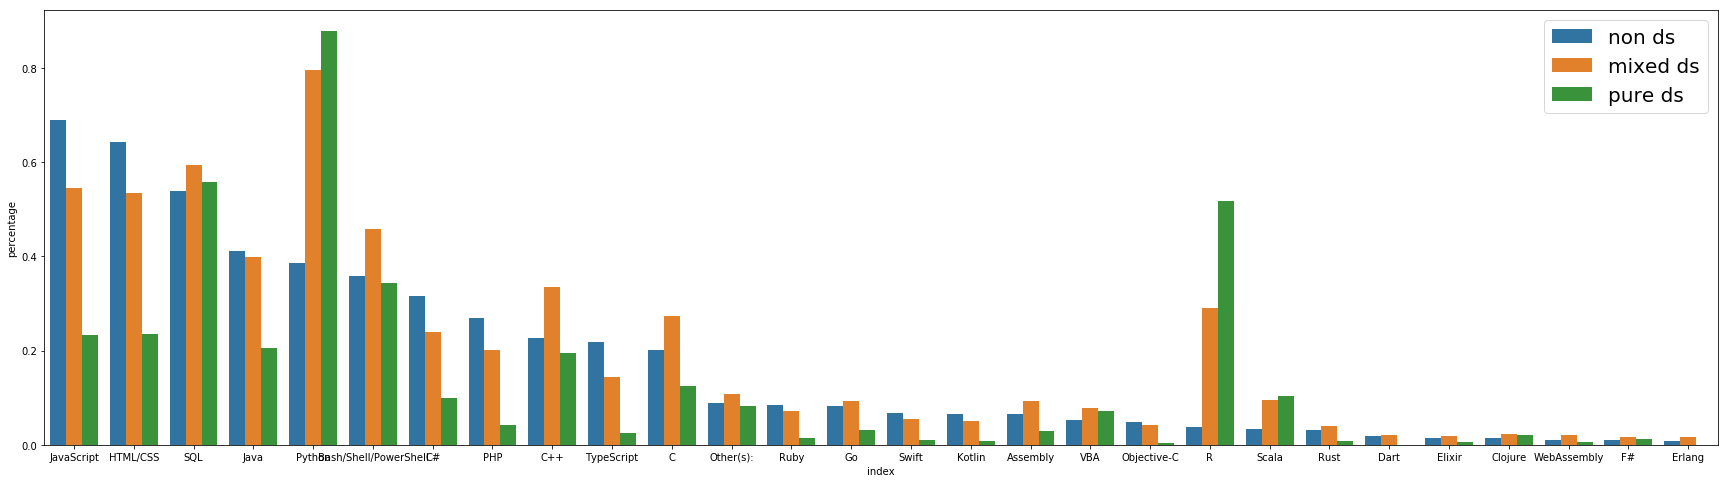

In [17]:
barplot_group('LanguageWorkedWith',30,8)

The top 3 languages for mixed data scientist are Python, SQL and JavaScript. While more than 80% of pure data scientist use Python, SQL and R are also popular. This is so true that if you search "Python SQL R" in a job board website, it will return data scientist jobs. Beyond the programming language, we take a look DatabaseWorkedWith, PlatformWorkedWith, WebFrameWorkedWith, MiscTechWorkedWith, DevEnviron, OpSys. These developer tools might differ across 3 group. 

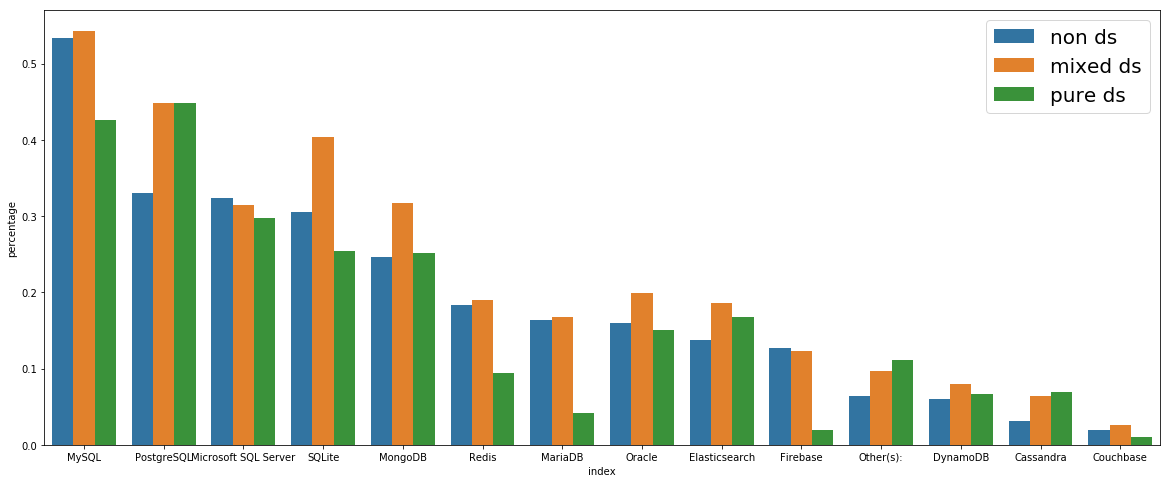

In [18]:
barplot_group('DatabaseWorkedWith')

Non data scientists use MySQL a lot while pure data scientist use PostgreSQL, I think the reason is they have a different working platform. Let's see check the platform.

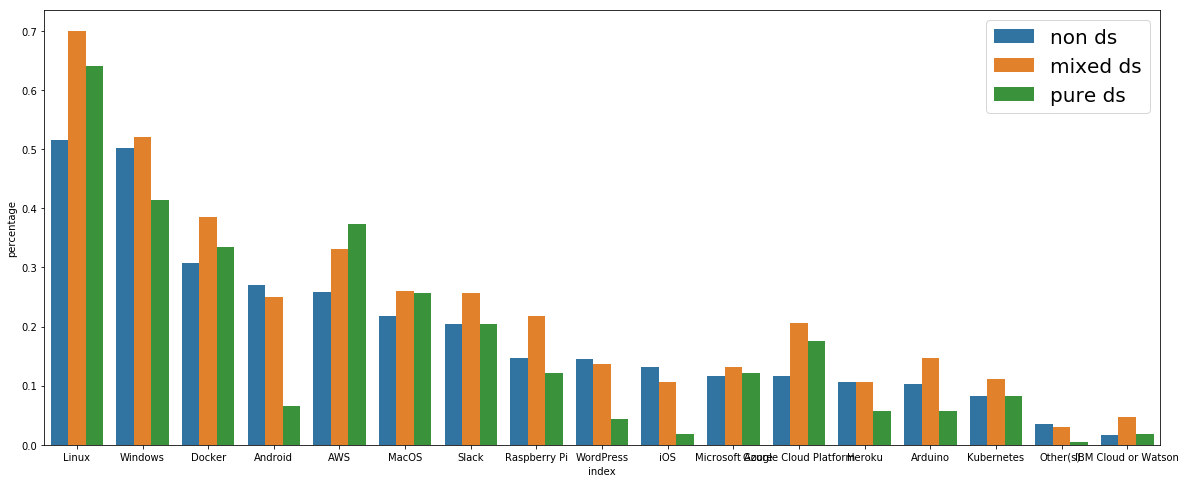

In [19]:
barplot_group('PlatformWorkedWith')

Linux is the top working platform for every developer, Windows also is a important working platform traditionally. There are recently new platforms such as AWS and Docker.

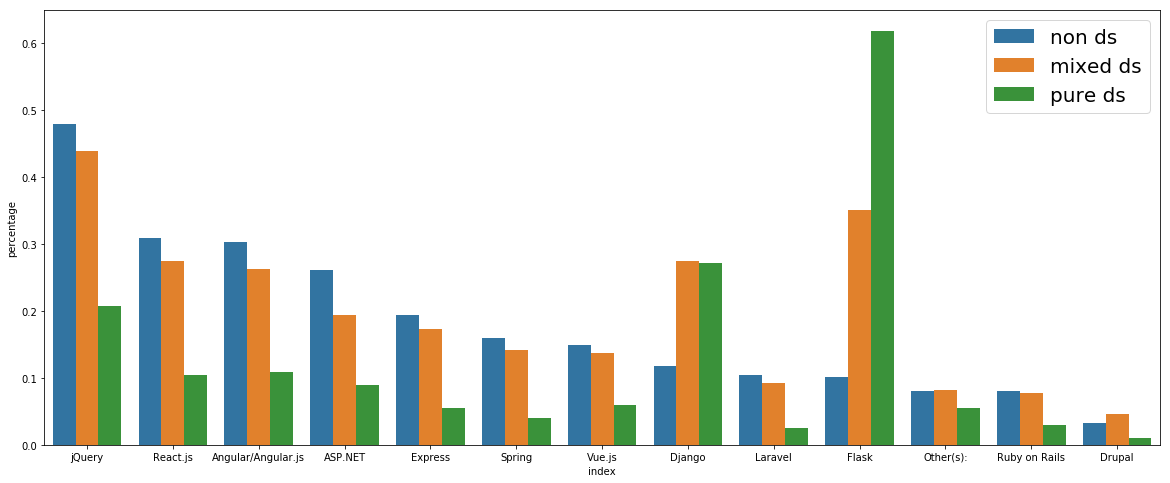

In [20]:
barplot_group('WebFrameWorkedWith')

Non data scientists use JQuery while pure data scientist prefers Flask, which is a Python based web framework. It looks like WebFrameWorkedWith is somewhat correlated with LanguageWorkedWith, as well as they are correlated with MiscTechWorkedWith:

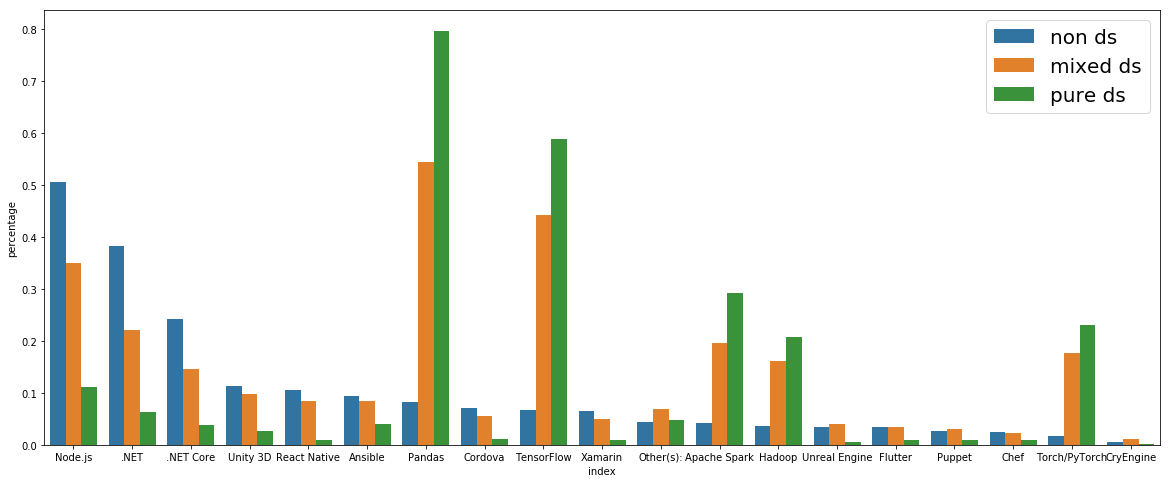

In [21]:
barplot_group('MiscTechWorkedWith')

Data scientists use Pandas, Tensorflow, a machine learning library, also Spark, Hadoop and PyTorch. All these tools are based on Python or with a Python access API. No wonder more than 80% of pure data scientists are using Python! I expect that DevEnviron is also correlated.

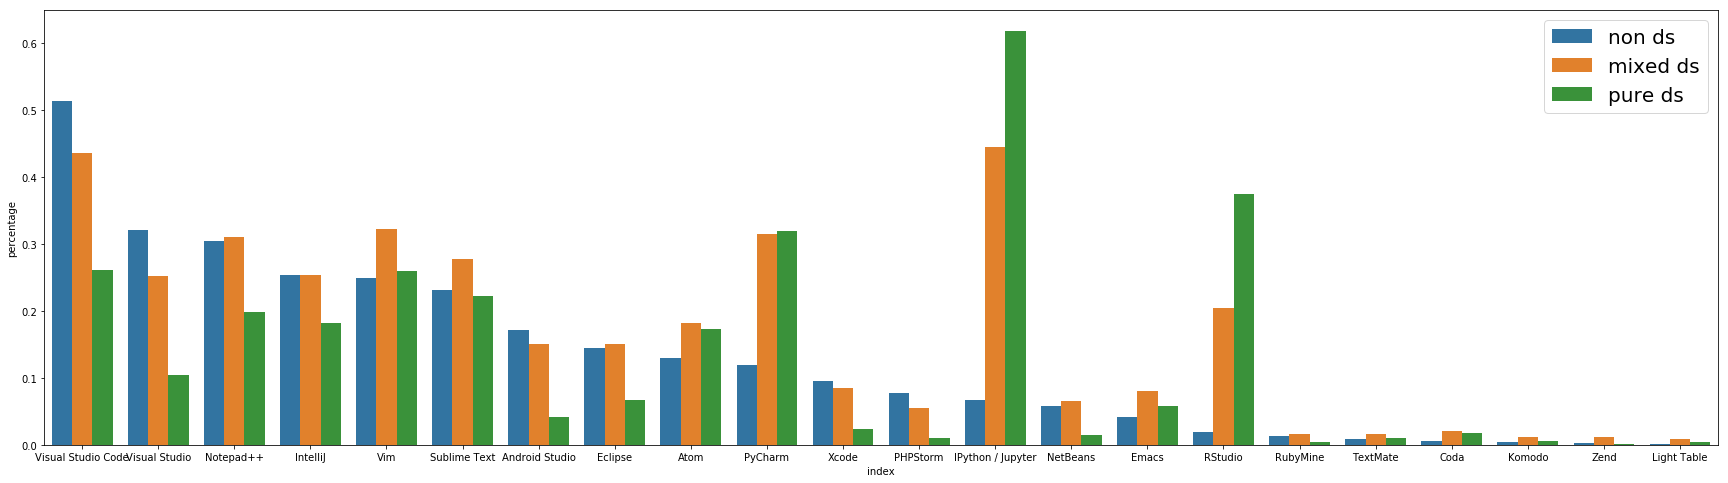

In [22]:
barplot_group('DevEnviron',30,8)

Top 3 developing editors for pure data scientist are Jupyter, PyCharm and RStudio, which is corresponding to what we've found, they use Python and R.

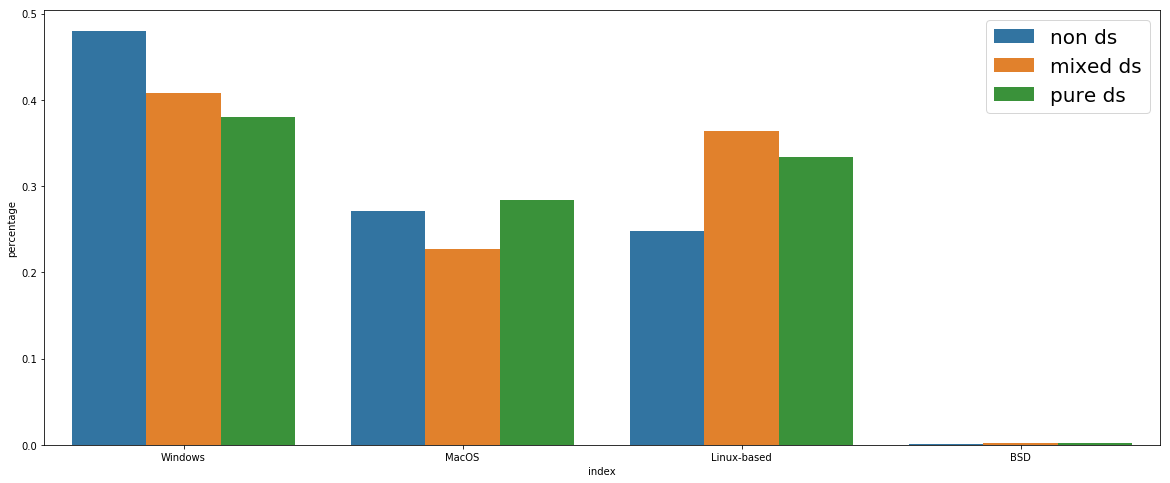

In [23]:
barplot_group('OpSys')

Let's see the the survey question of OpSys: What is the primary operating system in which you work? It indicates the system you are commonly working with including sending emails with Outlook and using MS Office production. Therefore, it's no doubt the result returns Windows as the top operation system. Data scientists prefer Linux then MacOS as we've known they work on Linux mostly. 

I am interested if a network graph is able to explain the correlation among these technologies and tools. I want to gather all these tools and use networkx package to generate a technology network for data scientist. The first step, I need to create a co-occurence matrix for these technology variables.

In [24]:
# Explore the pure data scientist group
# data_scientist = survey_2019[survey_2019['DevType'].str.contains("Data scientist",na = False)]

# Gather the technology variables
temp = pure_data_scientist[['LanguageWorkedWith'
                                ,'DatabaseWorkedWith'
                                ,'PlatformWorkedWith'
                                ,'WebFrameWorkedWith'
                                ,'MiscTechWorkedWith'
                                ,'DevEnviron'
                                ]]

# Create a tech combining all technologies into one variable.
temp['tech'] = temp['LanguageWorkedWith'].map(str)+";"+temp['DatabaseWorkedWith'].map(str)+";"+temp['PlatformWorkedWith'].map(str)+";"+temp['WebFrameWorkedWith'].map(str)+";"+temp['MiscTechWorkedWith'].map(str)+";"+temp['DevEnviron'].map(str)

# Transpose tech to build a one hot matrix 
df = pd.get_dummies(temp['tech'].str.split(';', expand=True)
   .stack()
   ).sum(level=0)

# drop the nan column
df = df.drop(columns=['nan'])

# Convert the value to integer.
df_asint = df.astype(int)

# Create co-occurrence matrix
coocc = df_asint.T.dot(df_asint)
coocc

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


.NET  .NET Core  ASP.NET  AWS  Android  Android Studio  \
.NET         27         11       13   12        5               4   
.NET Core    11         16       11    8        4               3   
ASP.NET      13         11       18    7        4               3   
AWS          12          8        7  163        5               4   
Android       5          4        4    5       29              15   
...         ...        ...      ...  ...      ...             ...   
Xamarin       3          2        3    1        3               1   
Xcode         1          1        1    4        2               3   
Zend          0          0        0    0        0               1   
iOS           1          1        1    1        4               3   
jQuery        8          5        6   15        4               2   

           Angular/Angular.js  Ansible  Apache Spark  Arduino  Assembly  Atom  \
.NET                        5        4             7        2         5     2   
.NET Core                   5        3             5        1         2     1   
ASP.NET                     4        3             3        1         3     2   
AWS                         9       11            54       12         7    35   
Android                     4        3             5        3         4     2   
...                       ...      ...           ...      ...       ...   ...   
Xamarin                     2        1             0        0         1     1   
Xcode                       1        2             3        0         1     3   
Zend                        0        0             0        0         0     1   
iOS                         1        0             1        1         0     1   
jQuery                      8        5            12        5         3     9   

           Bash/Shell/PowerShell   C  C#  C++  Cassandra  Chef  Clojure  Coda  \
.NET                          11   7  24    9          4     0        0     0   
.NET Core                      7   3  16    6          2     0        0     0   
ASP.NET                        5   3  17    6          3     0        0     0   
AWS                           74  21  20   28         14     2        6     3   
Android                        9  15   9   20          3     1        0     1   
...                          ...  ..  ..  ...        ...   ...      ...   ...   
Xamarin                        1   1   4    2          0     0        0     0   
Xcode                          5   3   2    3          3     1        0     2   
Zend                           0   0   0    0          1     0        0     1   
iOS                            3   3   2    4          3     0        0     0   
jQuery                        20  10  12   12          7     1        0     1   

           Cordova  Couchbase  CryEngine  Django  Docker  Drupal  DynamoDB  \
.NET             1          0          0       5      12       0         4   
.NET Core        0          0          0       4       9       0         2   
ASP.NET          0          0          0       4       7       0         2   
AWS              3          2          0      24      83       1        24   
Android          3          2          0      10      10       1         0   
...            ...        ...        ...     ...     ...     ...       ...   
Xamarin          0          0          0       1       2       0         1   
Xcode            1          1          0       2       2       0         1   
Zend             0          0          0       0       0       0         0   
iOS              1          0          0       1       2       0         0   
jQuery           2          1          1       9      17       1         5   

           Eclipse  Elasticsearch  Elixir  Emacs  Express  F#  Firebase  \
.NET             2              7       2      3        4   5         2   
.NET Core        1              3       0      0        3   4         2   
ASP.NET          2              1       0      0        3   5         2   

In [25]:
# networkx time              
# create edges with weight, and a note list
edge_list = []
node_list = []
for index, row in coocc.iterrows():
    i = 0
    for col in row:
        weight = float(col)/df.shape[0]
        
        if weight >=0.2:    # ignore weak weight.
            
            if index != coocc.columns[i]:
                edge_list.append((index, coocc.columns[i], weight))
            
            #create a note list
            if index == coocc.columns[i]:
                node_list.append((index, weight))
        i += 1


In [26]:
# networkx graph
G = nx.Graph()
for i in sorted(node_list):
    G.add_node(i[0], size = i[1])
G.add_weighted_edges_from(edge_list)

# create a list for edges width.
test = nx.get_edge_attributes(G, 'weight')
edge_width = []
for i in nx.edges(G):
    for x in iter(test.keys()):
        if i[0] == x[0] and i[1] == x[1]:
            edge_width.append(test[x])

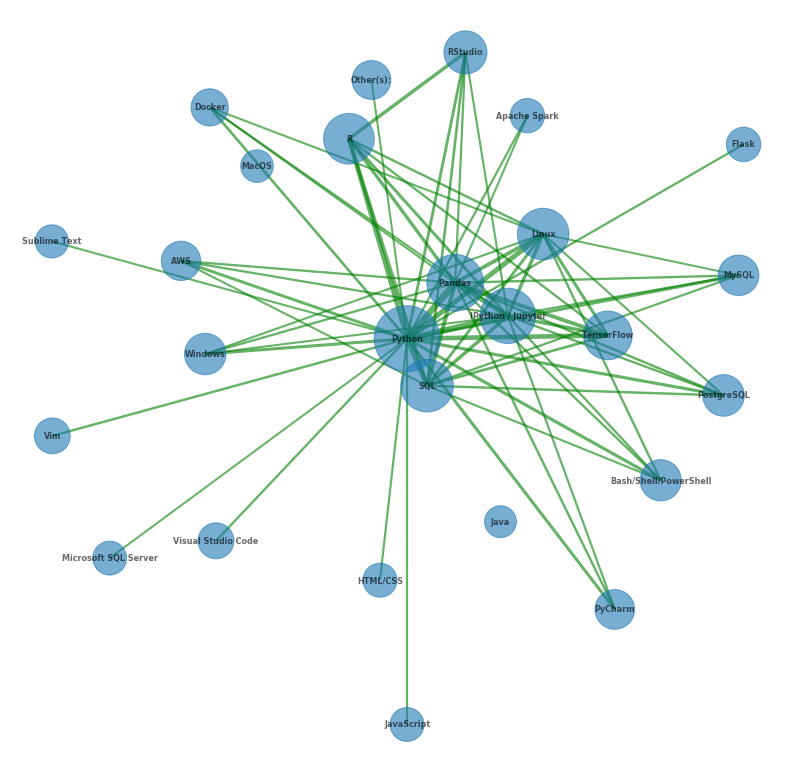

In [27]:
plt.subplots(figsize=(14,14))
node_scalar = 5000
width_scalar = 10
sizes = [x[1]*node_scalar for x in node_list]
widths = [x*width_scalar for x in edge_width]

#draw the graph
pos = nx.spring_layout(G, k=0.4, iterations=15,seed=1234)

nx.draw(G, pos, with_labels=True, font_size = 8, font_weight = 'bold', 
        node_size = sizes, width = widths,alpha=0.6,edge_color="green")

The bigger note indicates the larger percentage of pure data scientists who use the tool. It's obvious Python is a core skill for data scientist, it connects to almost all data science tool, I regard this as Python ecosystem. 

<a class="anchor" id="3.3"></a>
### 3.3 Education

Next we move to analyze the education background of data scientist. First, we look into EdLevel, which shows the highest education level of developers.

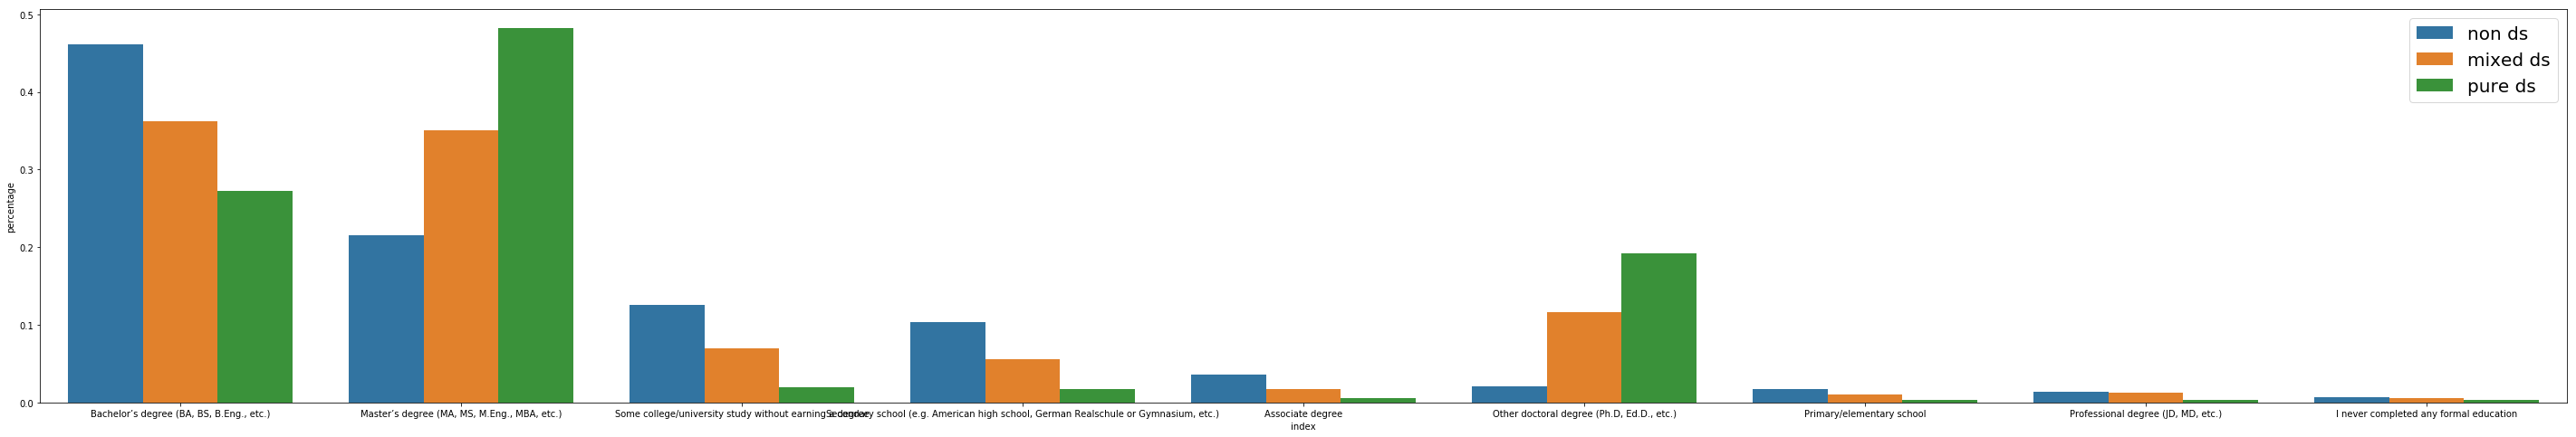

In [28]:
barplot_group('EdLevel',50,8)

 It looks like the data scientists tend to have a higher education degree than non data scientists. The majority of pure data scientists has a master degree, and it seems Ph.Ds are more common in data science. I am interested in what field the data scientist study. Let's look into UndergradMajor.

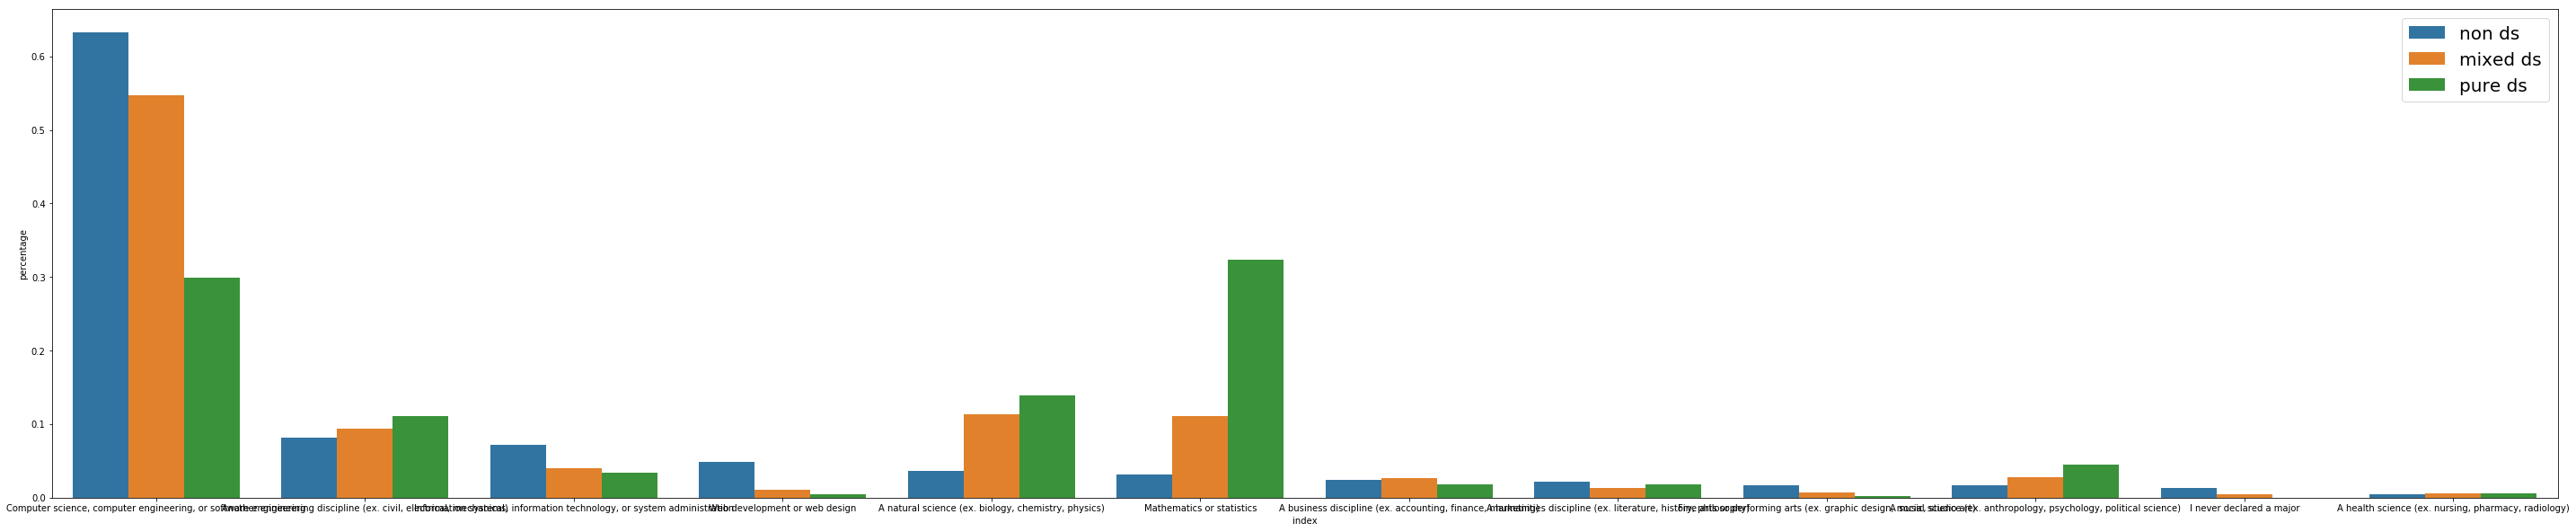

In [29]:
barplot_group('UndergradMajor',50,10)

No surprise that most data scientists earn a computer science or engineer degree. There is a large portion of pure data scientist earning a mathematics and statistics degree. I am curious about the people who has social science background. Let's see the data.

In [30]:
survey_2019['UndergradMajor'].value_counts(dropna=False)

Computer science, computer engineering, or software engineering          47214
NaN                                                                      13269
Another engineering discipline (ex. civil, electrical, mechanical)        6222
Information systems, information technology, or system administration     5253
Web development or web design                                             3422
A natural science (ex. biology, chemistry, physics)                       3232
Mathematics or statistics                                                 2975
A business discipline (ex. accounting, finance, marketing)                1841
A humanities discipline (ex. literature, history, philosophy)             1571
A social science (ex. anthropology, psychology, political science)        1352
Fine arts or performing arts (ex. graphic design, music, studio art)      1233
I never declared a major                                                   976
A health science (ex. nursing, pharmacy, radiology) 

In [31]:
# Check the number of data scientist with social science background.
df = survey_2019[survey_2019['DevType'].str.contains("Data scientist",na = False)
                                  & (survey_2019['UndergradMajor']=='A social science (ex. anthropology, psychology, political science)')]
df.shape[0]

169

In [32]:
# What country do they reside in?
df['Country'].value_counts(dropna=False)

United States         92
Germany               11
United Kingdom         7
Canada                 5
Serbia                 4
Hungary                3
Belgium                3
Spain                  3
Brazil                 3
Netherlands            3
Switzerland            3
Australia              3
Czech Republic         2
France                 2
Philippines            2
Poland                 2
Italy                  2
Denmark                2
Ukraine                2
Ireland                1
Taiwan                 1
Bangladesh             1
Russian Federation     1
Thailand               1
Finland                1
Argentina              1
Austria                1
Iceland                1
Hong Kong (S.A.R.)     1
South Africa           1
Israel                 1
Norway                 1
Romania                1
Kenya                  1
Name: Country, dtype: int64

In [33]:
# The percentage of data scientists who reside in US. 
data_scientist = pd.concat([pure_data_scientist,mixed_data_scientist])
print(data_scientist[data_scientist['Country']=='United States'].shape[0]/data_scientist.shape[0])

0.2611455108359133


In [34]:
# The percentage of data scientists who reside in US grouping by undergraduate major.
df = data_scientist['UndergradMajor'].value_counts(dropna=False).sort_index().reset_index()
df1 = data_scientist[data_scientist['Country']=='United States']['UndergradMajor'].value_counts(dropna=False).sort_index().reset_index()
df2 = pd.merge(df,df1, on='index')
df2['PCT of US'] = df2['UndergradMajor_y']/df2['UndergradMajor_x']
df2

index  \
0              A business discipline (ex. accounting, finance, marketing)   
1                     A health science (ex. nursing, pharmacy, radiology)   
2           A humanities discipline (ex. literature, history, philosophy)   
3                     A natural science (ex. biology, chemistry, physics)   
4      A social science (ex. anthropology, psychology, political science)   
5      Another engineering discipline (ex. civil, electrical, mechanical)   
6         Computer science, computer engineering, or software engineering   
7    Fine arts or performing arts (ex. graphic design, music, studio art)   
8                                                I never declared a major   
9   Information systems, information technology, or system administration   
10                                              Mathematics or statistics   
11                                          Web development or web design   
12                                                                    NaN   

    UndergradMajor_x  UndergradMajor_y  PCT of US  
0                151                41   0.271523  
1                 36                 8   0.222222  
2                 82                36   0.439024  
3                671               204   0.304024  
4                169                92   0.544379  
5                558               168   0.301075  
6               3066               675   0.220157  
7                 36                24   0.666667  
8                 22                12   0.545455  
9                233                40   0.171674  
10               749               260   0.347130  
11                57                 7   0.122807  
12               630               120   0.190476

Comparing to other countries, the US accounts for a majority of data scientist who has an undergraduate degree of social science, art or humanities discipline. I wonder if data science recently grows on these fields in the US. Next, take a look the EduOther which shows other education like online course.

In [35]:
survey_2019['EduOther'].value_counts(dropna=False)

Taught yourself a new language, framework, or tool without taking a formal course                                                                                                                                                                                                                                                                        6699
Taken an online course in programming or software development (e.g. a MOOC);Taught yourself a new language, framework, or tool without taking a formal course                                                                                                                                                                                            6012
NaN                                                                                                                                                                                                                                                                                                         

In [36]:
total_count(non_data_scientist,'EduOther')

index  \
0  Taught yourself a new language, framework, or tool without taking a formal course   
1        Taken an online course in programming or software development (e.g. a MOOC)   
2                                                Contributed to open source software   
3                               Received on-the-job training in software development   
4                                                        Participated in a hackathon   
5   Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)   
6          Taken a part-time in-person course in programming or software development   
7                 Participated in a full-time developer training program or bootcamp   
8                            Completed an industry certification program (e.g. MCPD)   

   count  percentage  
0  66482    0.853044  
1  46105    0.591583  
2  31526    0.404517  
3  30704    0.393969  
4  19685    0.252582  
5  19333    0.248066  
6  14356    0.184205  
7  11901    0.152704  
8  11676    0.149817

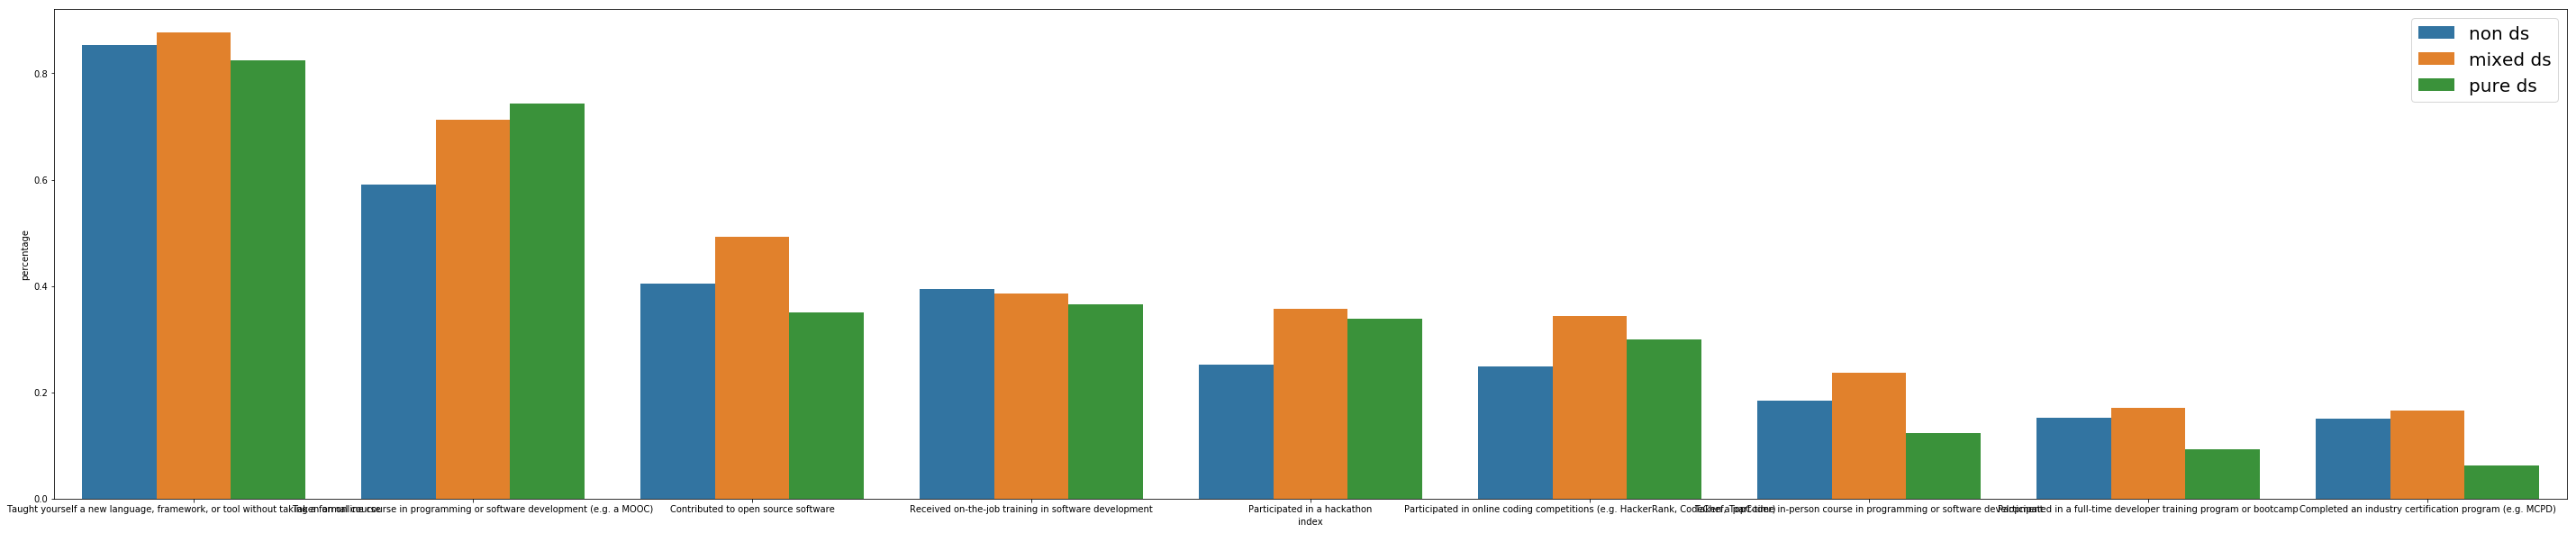

In [37]:
barplot_group('EduOther',50,10)

That seems not much difference between data scientist and non data scientist. Taught yourself a new language and taking online course are the most suggested education method beyond earning a degree.

<a class="anchor" id="4"></a>
## 4. Q2: What salary does data scientist earn comparing to other developer?



<a class="anchor" id="4.1"></a>
### 4.1 Age

First check the distribution of age among 3 groups. Can we distinguish data scientist with their age?

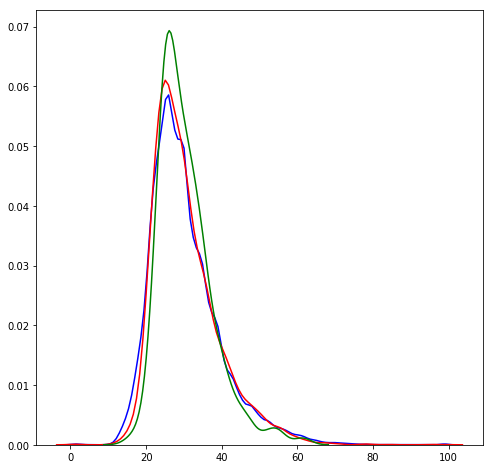

In [38]:
df1 = non_data_scientist[non_data_scientist['Age'].notnull()]
df2 = mixed_data_scientist[mixed_data_scientist['Age'].notnull()]
df3 = pure_data_scientist[pure_data_scientist['Age'].notnull()]

# density plot of age among 3 groups
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
sns.distplot(df1[['Age']], hist=False,color='blue',norm_hist=True)
sns.distplot(df2[['Age']], hist=False,color='red',norm_hist=True)
sns.distplot(df3[['Age']], hist=False,color='green',norm_hist=True)



Most developers are young between 20 and 40. A few developers is joking almost 100 years old. It looks like a larger portion of younger population for the data scientist.

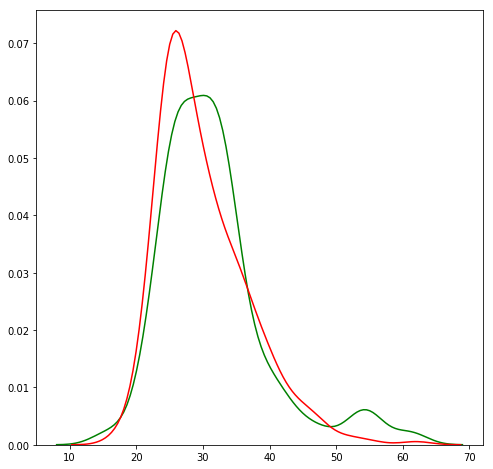

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)

# density plot of age of pure data scientist between residing in US and non-US.
sns.distplot(df3[df3['Country']=='United States'][['Age']], hist=False,color='green',norm_hist=True)
sns.distplot(df3[df3['Country']!='United States'][['Age']], hist=False,color='red',norm_hist=True)

<a class="anchor" id="4.2"></a>
### 4.2 Salary

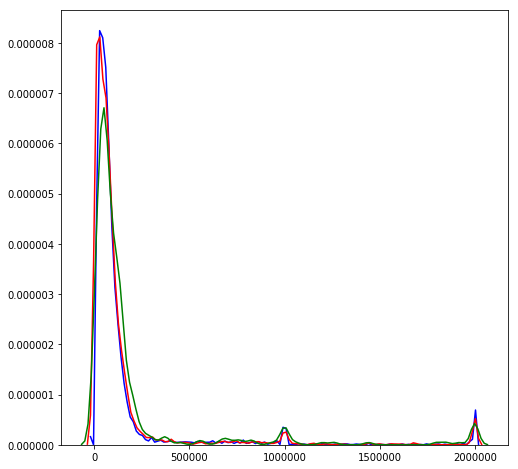

In [40]:
# Salaries among 3 groups 


df1 = non_data_scientist[non_data_scientist['ConvertedComp'].notnull()]
df2 = mixed_data_scientist[mixed_data_scientist['ConvertedComp'].notnull()]
df3 = pure_data_scientist[pure_data_scientist['ConvertedComp'].notnull()]
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
sns.distplot(df1[['ConvertedComp']], hist=False,color='blue',norm_hist=True)
sns.distplot(df2[['ConvertedComp']], hist=False,color='red',norm_hist=True)
sns.distplot(df3[['ConvertedComp']], hist=False,color='green',norm_hist=True)

It looks like data scientist has a higher salary than other developer.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


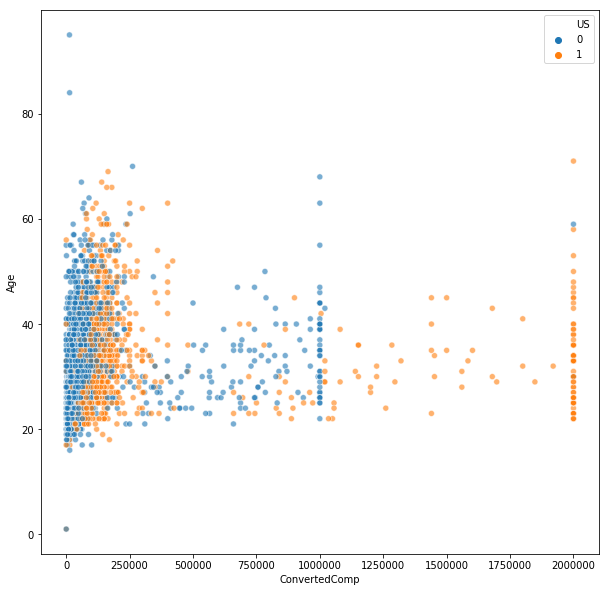

In [41]:
# Salary vs Age
df = survey_2019[survey_2019['DevType'].str.contains("Data scientist",na = False)]
df['US'] = df['Country'].apply(lambda x: 1 if x=='United States' else 0)


fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax = sns.scatterplot(x="ConvertedComp", y="Age", data=df, hue='US',alpha=0.6)

The people in US have higher salaries 

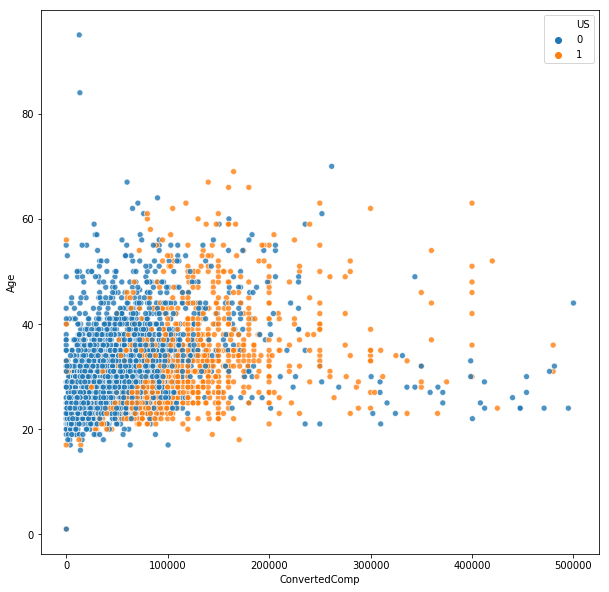

In [42]:
# Zoom in the compensations less than 500000 USD.
df1 = df[df["ConvertedComp"]<=500000]

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax = sns.scatterplot(x="ConvertedComp", y="Age", data=df1, hue='US',alpha=0.8)

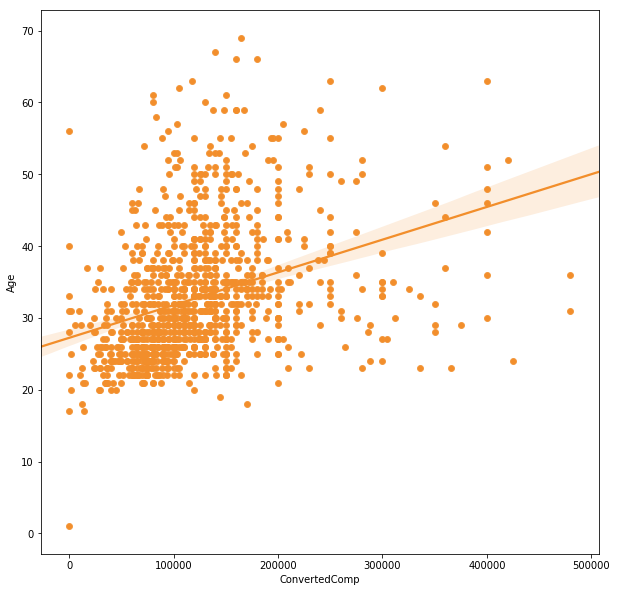

In [43]:
# Filter the data scientist in the US.

df2 = pd.concat([pure_data_scientist,mixed_data_scientist])
df2 = df2[(df2["ConvertedComp"]<=500000) & (df2["Country"]=='United States')]

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax = sns.scatterplot(x="ConvertedComp", y="Age", data=df2, color="#f28e2b")
ax = sns.regplot(x="ConvertedComp", y="Age", data=df2,color="#f28e2b")

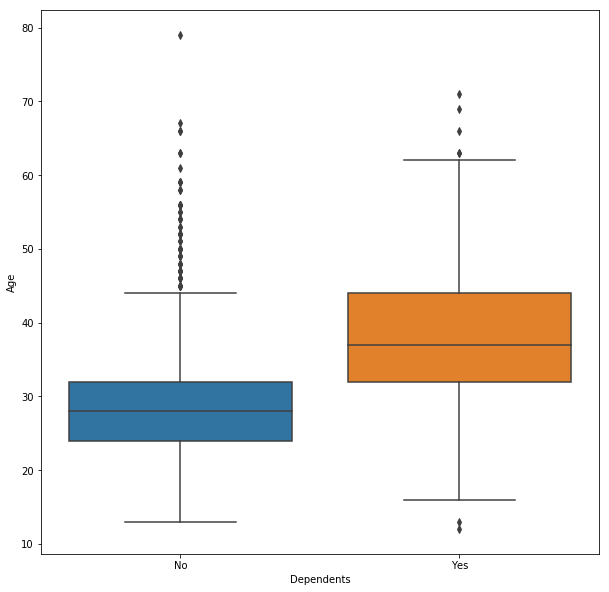

In [44]:
# Just curious whether US data scientist has any dependent.
df = survey_2019[survey_2019['DevType'].str.contains("Data scientist",na = False)]
df = df[df["Country"]=='United States']

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax = sns.boxplot(x="Dependents",y="Age" , data=df)

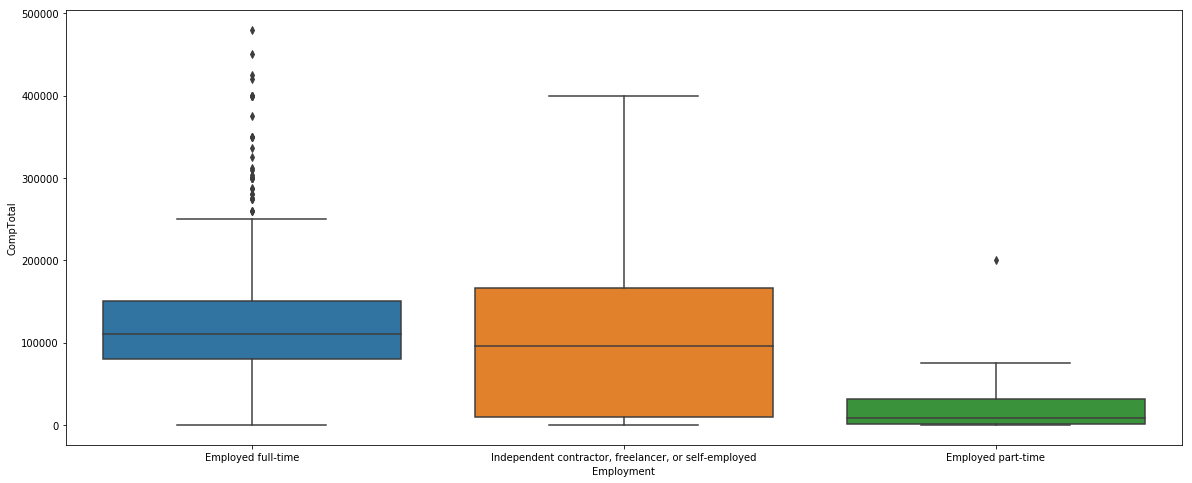

In [45]:
# Employment vs salary

fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
ax = sns.boxplot(x="Employment",y="CompTotal" , data=df2)

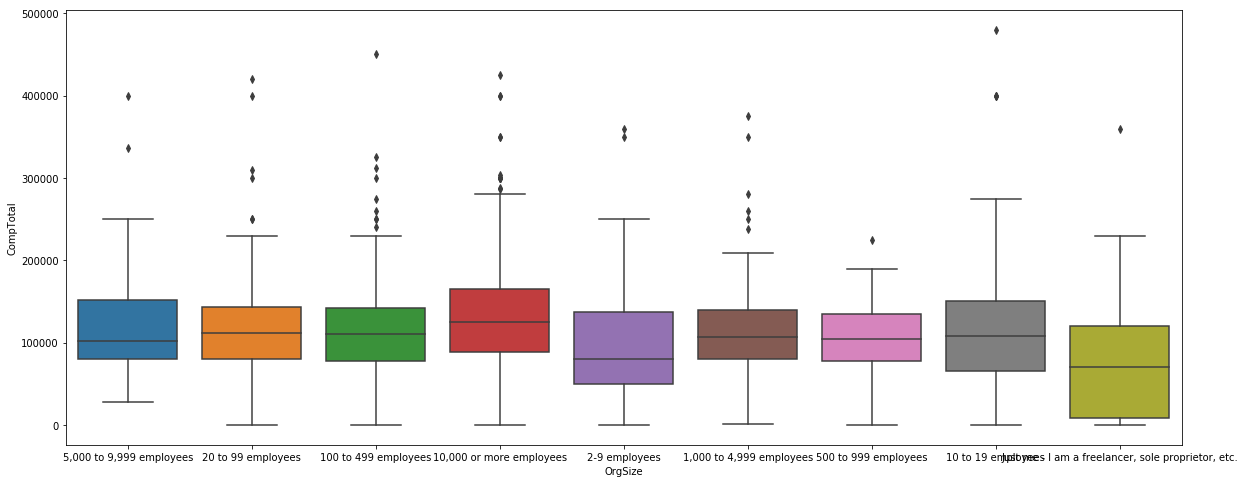

In [46]:
# OrgSize vs salary

fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
ax = sns.boxplot(x="OrgSize",y="CompTotal" , data=df2)

In [47]:
# df = survey_2019[survey_2019['DevType'].str.contains("Data scientist",na = False)]
# df = df[(df["Country"]=='United States')]
# df['CompTotal1'] = df.apply(lambda row : min(row['CompTotal'],row['ConvertedComp']),axis=1)

# fig, ax = plt.subplots()
# fig.set_size_inches(20, 20)
# ax = sns.scatterplot(x='CompTotal1', y="Age", data=df)

In [48]:
# df = survey_2019[survey_2019['DevType'].str.contains("Data scientist",na = False)]
# df = df[(df["Country"]=='United States')]
# df['CompTotal1'] = df.apply(lambda row : min(row['CompTotal'],row['ConvertedComp']),axis=1)
# df = df[df['CompTotal1'] <600000] 

# fig, ax = plt.subplots()
# fig.set_size_inches(20, 20)
# ax = sns.scatterplot(x='CompTotal1', y="Age", data=df)

<a class="anchor" id="4.3"></a>
### 4.3 Predict US Salary

The question is: What feature affect a data scientist salary? Skill, age, or company they work for? We already know that who resides in the US usually earns more than other countries. So we focus on analyzing US salary. 

In [49]:
# get the data first
df = survey_2019[survey_2019['DevType'].str.contains("Data scientist",na = False)]
df = df[df["Country"]=='United States']
df.shape

(1687, 85)

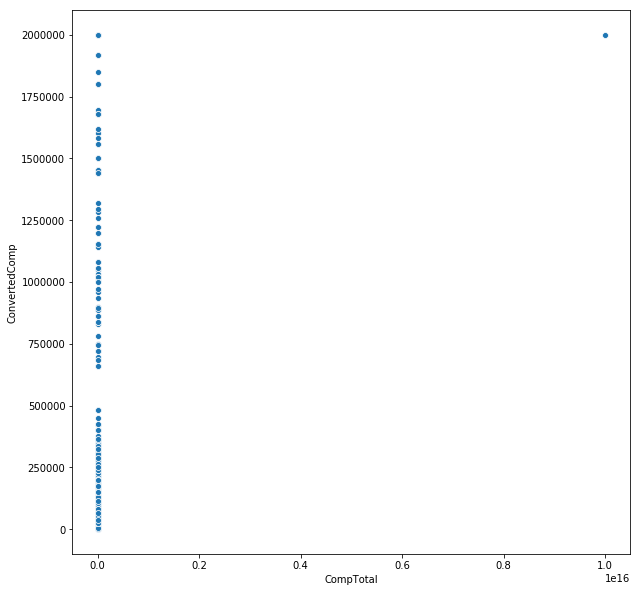

In [50]:
# Check CompTotal vs ConvertedComp, see which salary makes sense.
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax = sns.scatterplot(x='CompTotal', y="ConvertedComp", data=df)

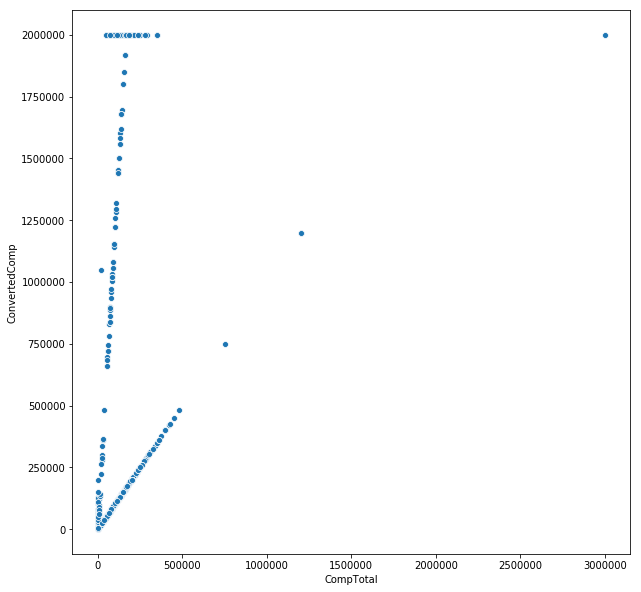

In [51]:
# One outlier for CompTotal, let me filter it out.
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax = sns.scatterplot(x='CompTotal', y="ConvertedComp", data=df[df["CompTotal"]<10000000])

Theotically they should be aligned, but not all. In the original survey form, there is only a box for compensation. It's possible ConvertedComp is a calculated variable. So I just consider CompTotal and drop ConvertedComp.


In [52]:
df['Employment'].value_counts(dropna=False)

Employed full-time                                      1383
Independent contractor, freelancer, or self-employed     138
Not employed, but looking for work                        89
Employed part-time                                        77
Name: Employment, dtype: int64

In [53]:
# Remove records with missing CompTotal and outliers;
df = df[(df['CompTotal'].notnull()) & (df['CompTotal']<700000) & (df['CompTotal']>0)]

# Exclude the unemployed.
df = df[df['Employment']!='Not employed, but looking for work']

# Drop ConvertedComp, Respondent, Country, DevType, CurrencySymbol,CurrencyDesc
df = df.drop(['ConvertedComp', 'Respondent', 'Country', 'DevType', 'CurrencySymbol','CurrencyDesc'],axis=1)
df.shape

(1230, 79)

In [54]:
# Retrieve the categorical variables
cat_vars_int = df.select_dtypes(include=['object']).copy().columns
len(cat_vars_int)

75

In [55]:
# Split and transpose the categorical variable into one-hot columns.
for var in  cat_vars_int:
    # for each cat add dummy var, drop original column
    df = pd.concat([df.drop(var, axis=1), df[var].str.get_dummies(sep=';').rename(lambda x: var+'_' + x, axis='columns')], axis=1)

df.describe()

CompTotal  WorkWeekHrs  CodeRevHrs          Age  \
count    1230.000000  1222.000000  851.000000  1162.000000   
mean   116779.861789    43.713011    4.002350    32.707831   
std     69169.716255     9.623734    4.853315     8.888440   
min         1.000000     1.000000    0.000000     1.000000   
25%     75000.000000    40.000000    2.000000    26.000000   
50%    108000.000000    40.000000    3.000000    31.000000   
75%    149500.000000    50.000000    5.000000    37.000000   
max    480000.000000   112.000000   98.900000    69.000000   

       MainBranch_I am a developer by profession  \
count                                1230.000000   
mean                                    0.777236   
std                                     0.416271   
min                                     0.000000   
25%                                     1.000000   
50%                                     1.000000   
75%                                     1.000000   
max                                     1.000000   

       MainBranch_I am not primarily a developer, but I write code sometimes as part of my work  \
count                                                                               1230.000000   
mean                                                                                   0.222764   
std                                                                                    0.416271   
min                                                                                    0.000000   
25%                                                                                    0.000000   
50%                                                                                    0.000000   
75%                                                                                    0.000000   
max                                                                                    1.000000   

       Hobbyist_No  Hobbyist_Yes  \
count  1230.000000   1230.000000   
mean      0.153659      0.846341   
std       0.360768      0.360768   
min       0.000000      0.000000   
25%       0.000000      1.000000   
50%       0.000000      1.000000   
75%       0.000000      1.000000   
max       1.000000      1.000000   

       OpenSourcer_Less than once a month but more than once per year  \
count                                                     1230.000000   
mean                                                         0.256911   
std                                                          0.437107   
min                                                          0.000000   
25%                                                          0.000000   
50%                                                          0.000000   
75%                                                          1.000000   
max                                                          1.000000   

       OpenSourcer_Less than once per year  OpenSourcer_Never  \
count                          1230.000000        1230.000000   
mean                              0.291870           0.320325   
std                               0.454808           0.466791   
min                               0.000000           0.000000   
25%                               0.000000           0.000000   
50%                               0.000000           0.000000   
75%                               1.000000           1.000000   
max                               1.000000           1.000000   

       OpenSourcer_Once a month or more often  \
count                             1230.000000   
mean                                 0.130894   
std                                  0.337422   
min                                  0.000000   
25%                                  0.000000   
50%                                  0.000000   
75%                                  0.000000   
max                                  1.000000   

       OpenSource_OSS is, on average, of HIGHER quality than proprietary / close

In [56]:
df.isnull().mean().sort_values(ascending=False)

CodeRevHrs                                                              0.308130
Age                                                                     0.055285
WorkWeekHrs                                                             0.006504
SurveyEase_Neither easy nor difficult                                   0.000000
JobSeek_I’m not actively looking, but I am open to new opportunities    0.000000
                                                                          ...   
WebFrameDesireNextYear_Express                                          0.000000
WebFrameDesireNextYear_Drupal                                           0.000000
WebFrameDesireNextYear_Django                                           0.000000
WebFrameDesireNextYear_Angular/Angular.js                               0.000000
CompTotal                                                               0.000000
Length: 628, dtype: float64

In [57]:
# Impute missing values with column median
df['CodeRevHrs'] = df['CodeRevHrs'].fillna(df['CodeRevHrs'].median())
df['Age'] = df['Age'].fillna(df['Age'].median())
df['WorkWeekHrs'] = df['WorkWeekHrs'].fillna(df['WorkWeekHrs'].median())

In [58]:
# An option reducing features to prevent overfitting?
# df = df.iloc[:, np.where((X.sum() > 10) == True)[0]]
# df.shape

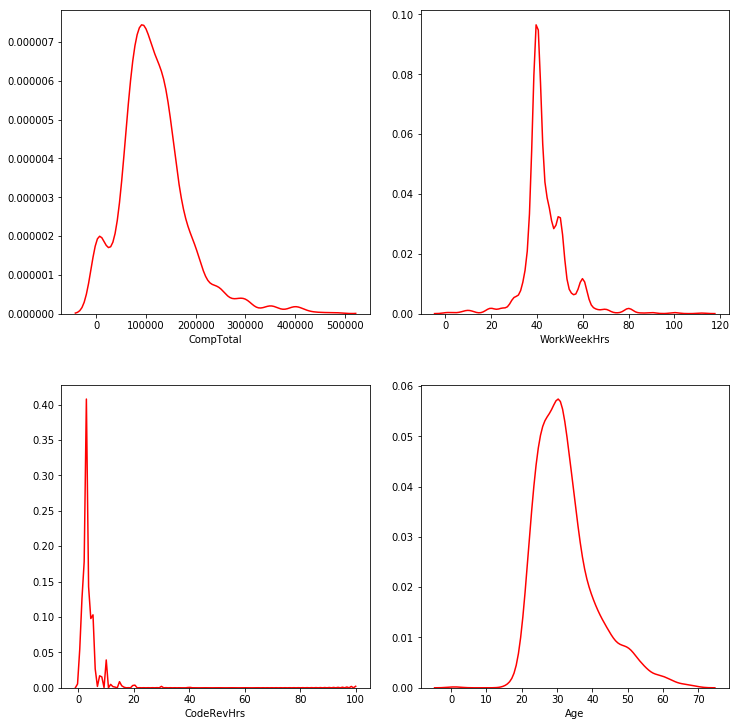

In [59]:
# Plot the distribution of numeric variables, see if any skewed distribution that needs to be normailized. 

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
plt.tight_layout(w_pad=2.0, h_pad=5.0)



plt.subplot(2,2,1)
plt.xlabel('CompTotal')
p1 = sns.distplot(df[['CompTotal']], hist=False,color='red',norm_hist=True)

plt.subplot(2,2,2)
plt.xlabel('WorkWeekHrs')
p2 = sns.distplot(df[['WorkWeekHrs']], hist=False,color='red',norm_hist=True)

plt.subplot(2,2,3)
plt.xlabel('CodeRevHrs')
p3 = sns.distplot(df[['CodeRevHrs']], hist=False,color='red',norm_hist=True)

plt.subplot(2,2,4)
plt.xlabel('Age')
p4 = sns.distplot(df[['Age']], hist=False,color='red',norm_hist=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


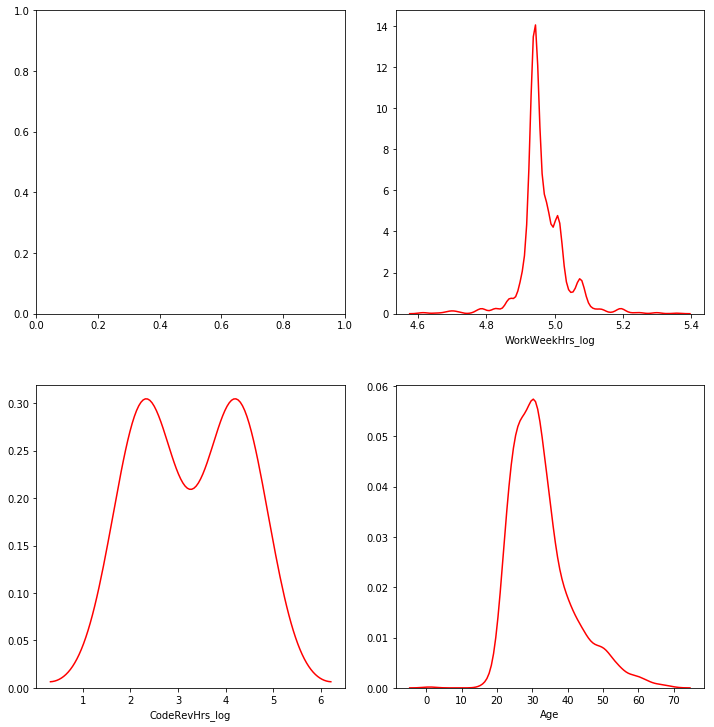

In [60]:
# Use logarithm function to transform the numeric columns
# df['CompTotal_log'] = np.log(df['CompTotal']+100000)
df['WorkWeekHrs_log'] =np.log(df['WorkWeekHrs']+100)
df['CodeRevHrs_log'] = np.log(df['CodeRevHrs']-30)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
plt.tight_layout(w_pad=2.0, h_pad=5.0)



# plt.subplot(2,2,1)
# plt.xlabel('CompTotal_log')
# p1 = sns.distplot(df[['CompTotal_log']], hist=False,color='red',norm_hist=True)

plt.subplot(2,2,2)
plt.xlabel('WorkWeekHrs_log')
p2 = sns.distplot(df[['WorkWeekHrs_log']], hist=False,color='red',norm_hist=True)

plt.subplot(2,2,3)
plt.xlabel('CodeRevHrs_log')
p3 = sns.distplot(df[['CodeRevHrs_log']], hist=False,color='red',norm_hist=True)

plt.subplot(2,2,4)
plt.xlabel('Age')
p4 = sns.distplot(df[['Age']], hist=False,color='red',norm_hist=True)

In [61]:
# Drop the original numeric columns
df = df.drop(['WorkWeekHrs','CodeRevHrs'],axis=1)

In [62]:
# Split the data into train and test
y = df['CompTotal'].values
X = df.drop(['CompTotal'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)

Now we use Xgboost to predict the salary of data scientist. Xgboost is one of the best tree learning algorithm by which most people have won a Kaggle competition.

In [63]:
# Xgboost modelling
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [64]:
evals_result = {}


xgb_pars = {'min_child_weight': 5, 'eta':0.5, 'colsample_bytree': 0.8, 
            'max_depth': 10,
'subsample': 0.8, 'lambda': 100000, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear','seed':1234}

model = xgb.train(xgb_pars, dtrain, 10000000, watchlist, early_stopping_rounds=15,
      maximize=False, verbose_eval=1000, evals_result=evals_result)
print('Modeling RMSE %.5f' % model.best_score)

[0]	train-rmse:132606	valid-rmse:143268
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 15 rounds.
[1000]	train-rmse:56357.2	valid-rmse:72638.5
[2000]	train-rmse:49926.3	valid-rmse:68981.8
[3000]	train-rmse:45906.3	valid-rmse:67024.7
[4000]	train-rmse:42797.4	valid-rmse:65783.1
[5000]	train-rmse:40204.7	valid-rmse:64941.3
[6000]	train-rmse:37953.5	valid-rmse:64353.7
[7000]	train-rmse:35955.6	valid-rmse:63939.4
[8000]	train-rmse:34130	valid-rmse:63651
Stopping. Best iteration:
[8041]	train-rmse:34060.4	valid-rmse:63639.8

Modeling RMSE 63639.84766


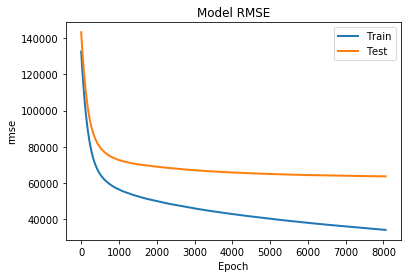

In [65]:
# Model evaluation graph
plt.plot(evals_result['train']['rmse'], linewidth=2, label='Train')
plt.plot(evals_result['valid']['rmse'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model RMSE')
plt.ylabel('rmse')
plt.xlabel('Epoch')
plt.show()

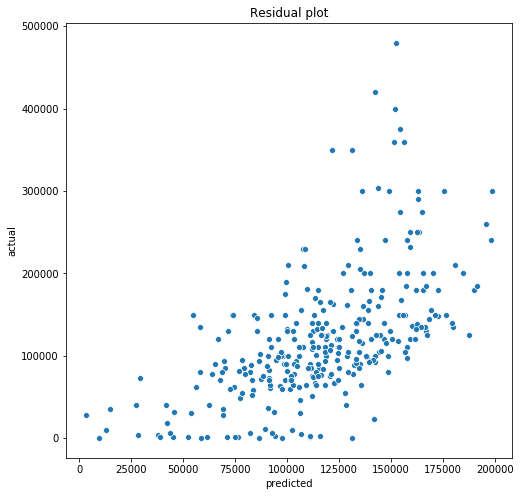

In [66]:
# 
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)

ax = sns.scatterplot(x=y_pred,y=y_test)
plt.title('Residual plot');
plt.xlabel('predicted');
plt.ylabel('actual'); 

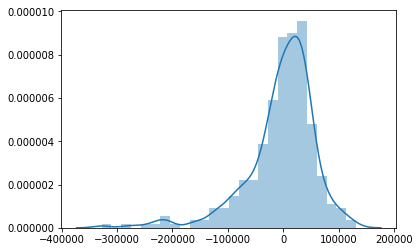

In [67]:
# histogram of residual
sns.distplot(y_pred-y_test)

We see there is an overfitting issue for the model. The residual is close to normal distribution, we can't say the model is bias. The next job maybe is tuning the model to find better parameters?

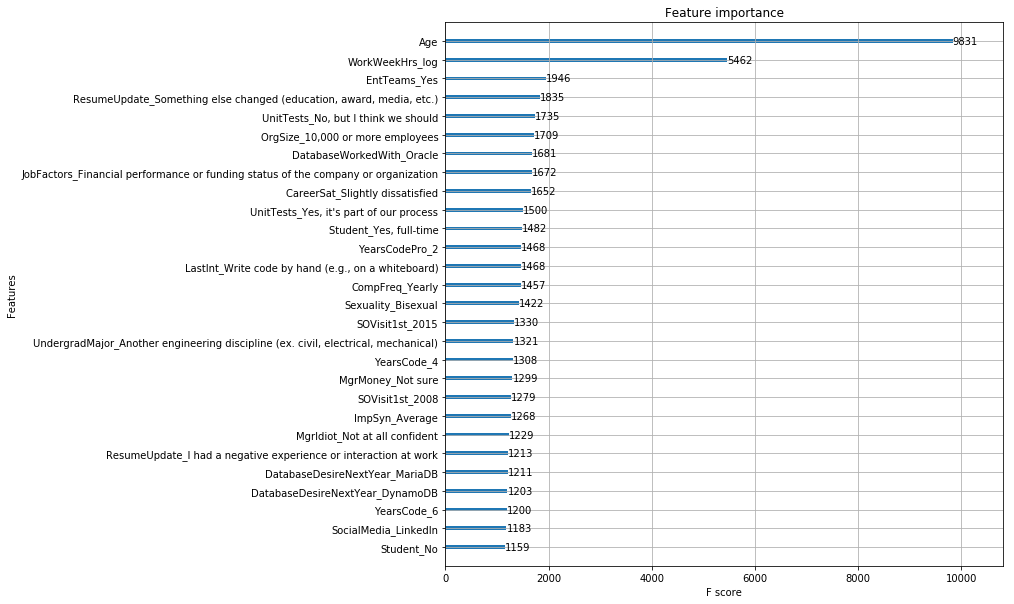

In [68]:
# Display the feature importance.
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
xgb.plot_importance(model, max_num_features=28, ax=ax)

We can see Age and Working hour are important features, data scientist who has more years of working experience and working hours can earn more, which likely make senses. Other features seem less relevant. This perhaps is the fact of the data scientist market, working harder and gaining experience, you would earn more, so does it mean that the boss does not care about their skills?

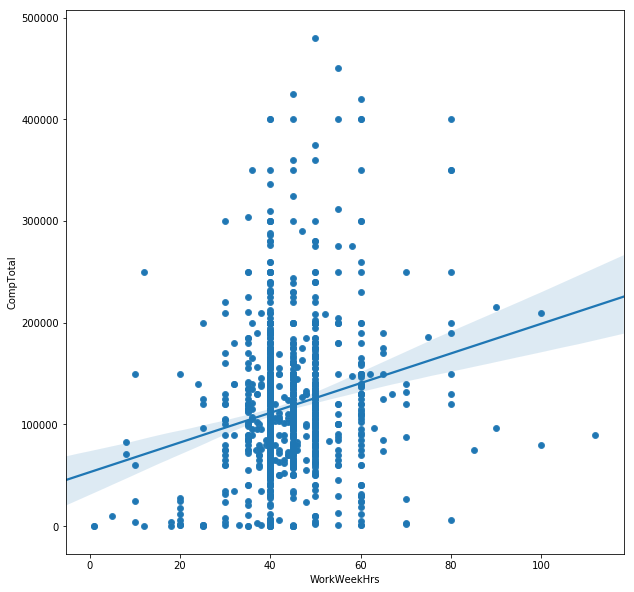

In [69]:
# Plot WorkWeekHrs vs CompTotal
# Check the tendency
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

df['WorkWeekHrs'] = np.exp(df['WorkWeekHrs_log'])-100
# ax = sns.boxplot(y='CompTotal', x="MgrMoney_Not sure", data=df[df["CompTotal"]<10000000])
# ax = sns.boxplot(y='CompTotal', x="OrgSize_10,000 or more employees", data=df[df["CompTotal"]<10000000])
ax = sns.scatterplot( x="WorkWeekHrs",y='CompTotal', data=df[df["CompTotal"]<10000000])
ax = sns.regplot(x="WorkWeekHrs", y="CompTotal", data=df[df["CompTotal"]<10000000])

In [70]:
# model = xgb.XGBRegressor(colsample_bytree=0.4,
#                  gamma=0,                 
#                  learning_rate=0.07,
#                  max_depth=3,
#                  min_child_weight=1.5,
#                  n_estimators=10000,                                                                    
#                  reg_alpha=0.75,
#                  reg_lambda=0.45,
#                  subsample=0.6,
#                  seed=42,
#                  verbose=10) 

In [71]:
# model.fit(X_train,y_train)

In [72]:
# predictions = model.predict(X_test)
# # print(explained_variance_score(predictions,y_test))
# from sklearn.metrics import mean_absolute_error
# print("Mean Absolute Error : " + str(mean_absolute_error(predictions, y_test)))

<a class="anchor" id="5"></a>
## 5. Q3: What features make data scientist distnct in this survey?

The basic idea to answer this question is to build a classifier model that distinguishes data scientist and non data scentist, then we can dig out the distinct feature by exploring the feature importance attribute of the model.

In [73]:
# Retrieve the character variables.
# df = survey_2019[survey_2019['Country']=='United States']
df = survey_2019
cat_vars_int = survey_2019.select_dtypes(include=['object']).copy().columns
len(cat_vars_int)
df.shape

(88883, 85)

In [74]:
# Again split and transpose the categorical variable into one-hot columns.
for var in  cat_vars_int:
    # for each cat add dummy var, drop original column
    df = pd.concat([df.drop(var, axis=1), df[var].str.get_dummies(sep=';').rename(lambda x: var+'_' + x, axis='columns')], axis=1)

df.describe()

Respondent     CompTotal  ConvertedComp   WorkWeekHrs    CodeRevHrs  \
count  88883.000000  5.594500e+04   5.582300e+04  64503.000000  49790.000000   
mean   44442.000000  5.519014e+11   1.271107e+05     42.127197      5.084308   
std    25658.456325  7.331926e+13   2.841523e+05     37.287610      5.513931   
min        1.000000  0.000000e+00   0.000000e+00      1.000000      0.000000   
25%    22221.500000  2.000000e+04   2.577750e+04     40.000000      2.000000   
50%    44442.000000  6.200000e+04   5.728700e+04     40.000000      4.000000   
75%    66662.500000  1.200000e+05   1.000000e+05     44.750000      6.000000   
max    88883.000000  1.000000e+16   2.000000e+06   4850.000000     99.000000   

                Age  MainBranch_I am a developer by profession  \
count  79210.000000                               88883.000000   
mean      30.336699                                   0.738938   
std        9.178390                                   0.439216   
min        1.000000                                   0.000000   
25%       24.000000                                   0.000000   
50%       29.000000                                   1.000000   
75%       35.000000                                   1.000000   
max       99.000000                                   1.000000   

       MainBranch_I am a student who is learning to code  \
count                                       88883.000000   
mean                                            0.114634   
std                                             0.318581   
min                                             0.000000   
25%                                             0.000000   
50%                                             0.000000   
75%                                             0.000000   
max                                             1.000000   

       MainBranch_I am not primarily a developer, but I write code sometimes as part of my work  \
count                                                                              88883.000000   
mean                                                                                   0.084819   
std                                                                                    0.278614   
min                                                                                    0.000000   
25%                                                                                    0.000000   
50%                                                                                    0.000000   
75%                                                                                    0.000000   
max                                                                                    1.000000   

       MainBranch_I code primarily as a hobby  \
count                            88883.000000   
mean                                 0.037577   
std                                  0.190173   
min                                  0.000000   
25%                                  0.000000   
50%                                  0.000000   
75%                                  0.000000   
max                                  1.000000   

       MainBranch_I used to be a developer by profession, but no longer am  \
count                                                         88883.000000   
mean                                                              0.017821   
std                                                               0.132302   
min                                                               0.000000   
25%                                                               0.000000   
50%                                                               0.000000   
75%                                                               0.000000   
max                                                               1.000000   

        Hobbyist_No  Hobbyist_Yes  \
count  88883.000000  88883.000000   
mean       0.198306      0.801694   
std 

In [75]:
df.shape

(88883, 1179)

In [76]:
# Drop Respondent and CompTotal. Comptotal is the salary before curreny conversion 
# It does not provide valuable information unless we focus on one country.
df = df.drop(['Respondent','CompTotal'],axis=1)

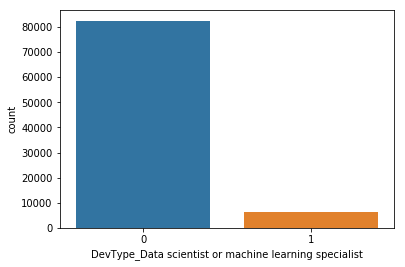

In [77]:
# Check the ratio of data scientist and non data scientist
sns.countplot(df['DevType_Data scientist or machine learning specialist'])

In [78]:
# Impute missing values with column median
df['CodeRevHrs'] = df['CodeRevHrs'].fillna(df['CodeRevHrs'].median())
df['Age'] = df['Age'].fillna(df['Age'].median())
df['WorkWeekHrs'] = df['WorkWeekHrs'].fillna(df['WorkWeekHrs'].median())
df['ConvertedComp'] = df['ConvertedComp'].fillna(df['ConvertedComp'].median())

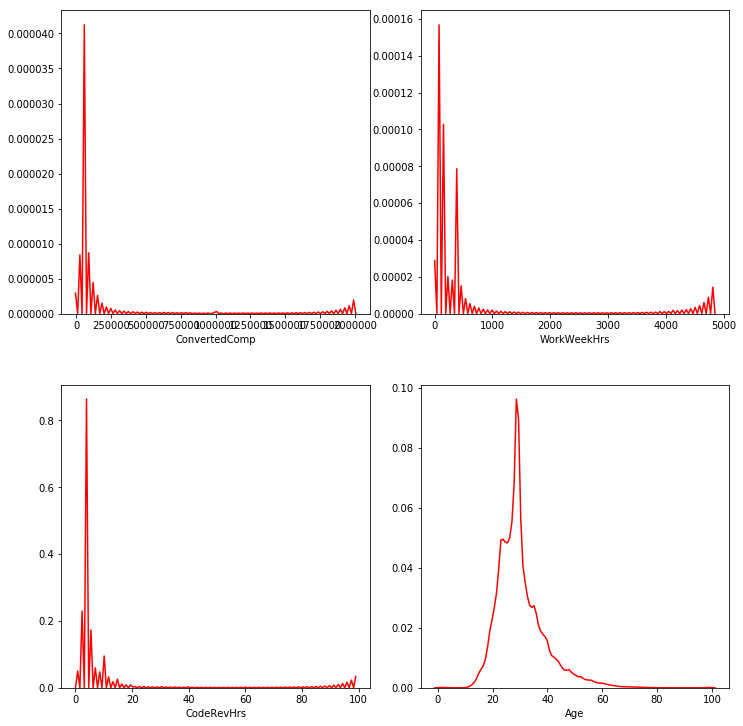

In [79]:
# See if the numeric variables need to be normalized.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
plt.tight_layout(w_pad=2.0, h_pad=5.0)

plt.subplot(2,2,1)
plt.xlabel('ConvertedComp')
p1 = sns.distplot(df[['ConvertedComp']], hist=False,color='red',norm_hist=True)

plt.subplot(2,2,2)
plt.xlabel('WorkWeekHrs')
p2 = sns.distplot(df[['WorkWeekHrs']], hist=False,color='red',norm_hist=True)

plt.subplot(2,2,3)
plt.xlabel('CodeRevHrs')
p3 = sns.distplot(df[['CodeRevHrs']], hist=False,color='red',norm_hist=True)

plt.subplot(2,2,4)
plt.xlabel('Age')
p4 = sns.distplot(df[['Age']], hist=False,color='red',norm_hist=True)

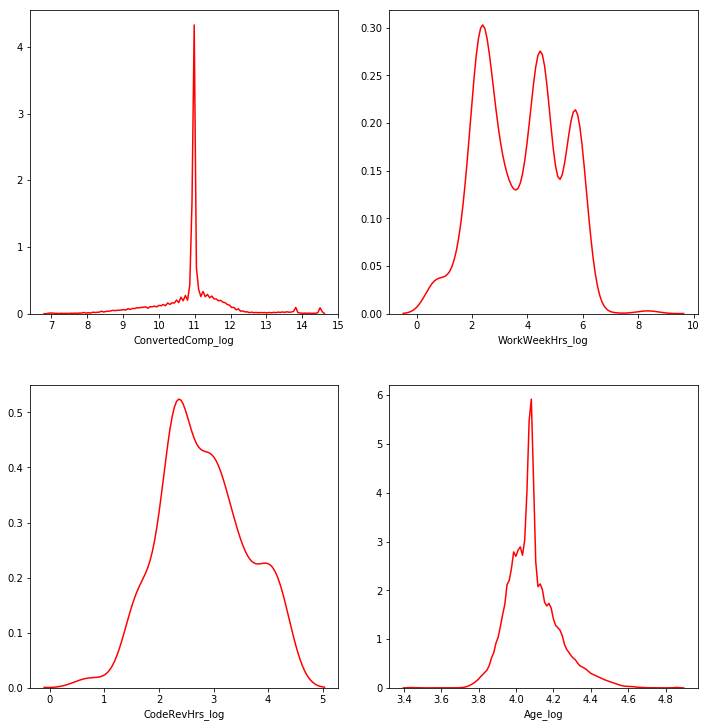

In [80]:
# Use logarithm function to transform the numeric columns
df['ConvertedComp_log'] = np.log(df['ConvertedComp']+1000)
df['WorkWeekHrs_log'] = np.log(df['WorkWeekHrs']-70)
df['CodeRevHrs_log'] = np.log(df['CodeRevHrs']-30)
df['Age_log'] = np.log(df['Age']+30)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
plt.tight_layout(w_pad=2.0, h_pad=5.0)

plt.subplot(2,2,1)
plt.xlabel('ConvertedComp_log')
p1 = sns.distplot(df[['ConvertedComp_log']], hist=False,color='red',norm_hist=True)

plt.subplot(2,2,2)
plt.xlabel('WorkWeekHrs_log')
p2 = sns.distplot(df[['WorkWeekHrs_log']], hist=False,color='red',norm_hist=True)

plt.subplot(2,2,3)
plt.xlabel('CodeRevHrs_log')
p3 = sns.distplot(df[['CodeRevHrs_log']], hist=False,color='red',norm_hist=True)

plt.subplot(2,2,4)
plt.xlabel('Age_log')
p4 = sns.distplot(df[['Age_log']], hist=False,color='red',norm_hist=True)

In [81]:
# Split data set into response vector and feature matrix.
y = df['DevType_Data scientist or machine learning specialist'].values
X = df.drop(['DevType_Data scientist or machine learning specialist'], axis=1)

In [82]:
# Drop original numeric columns. 
# We already know that researcher and data engineer might share the role of data scientist
# Drop DevType as it does not provide the information why data scientist is distinct. 

X = X.drop([col for col in X.columns if 'DevType_' in col],axis=1)
X = X.drop(['CodeRevHrs','ConvertedComp','WorkWeekHrs','Age'],axis=1)
X.shape

(88883, 1153)

In [83]:
# Split X y into training set and test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0,stratify=y)

In [84]:
# Define an Xgboost classifer
# Using AUPRC as the evaluation metric which is more sensitive to the minor class 
# As we know the population of data scientist is just 1/8 of other developers

model = xgb.XGBClassifier(
    learning_rate =0.1, n_estimators=1000,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic', 
    nthread=4,
    scale_pos_weight=7,
    seed=27,
    max_depth = 5,
    min_child_weight = 5
)

def evalauc(preds, dtrain):
    labels = dtrain.get_label()
    precision, recall, thresholds = precision_recall_curve(labels, preds)
    area = auc(recall, precision)
    return 'AUPRC', -area


model.fit(X_train, y_train,
          eval_metric=evalauc,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          early_stopping_rounds=5,
         verbose=True)

[0]	validation_0-error:0.13669	validation_1-error:0.138338	validation_0-AUPRC:-0.483305	validation_1-AUPRC:-0.467239
Multiple eval metrics have been passed: 'validation_1-AUPRC' will be used for early stopping.

Will train until validation_1-AUPRC hasn't improved in 5 rounds.
[1]	validation_0-error:0.136915	validation_1-error:0.137888	validation_0-AUPRC:-0.487788	validation_1-AUPRC:-0.469399
[2]	validation_0-error:0.107603	validation_1-error:0.109221	validation_0-AUPRC:-0.493681	validation_1-AUPRC:-0.473718
[3]	validation_0-error:0.111878	validation_1-error:0.114306	validation_0-AUPRC:-0.503593	validation_1-AUPRC:-0.483726
[4]	validation_0-error:0.116363	validation_1-error:0.119077	validation_0-AUPRC:-0.507652	validation_1-AUPRC:-0.488935
[5]	validation_0-error:0.114383	validation_1-error:0.117006	validation_0-AUPRC:-0.517724	validation_1-AUPRC:-0.495238
[6]	validation_0-error:0.113708	validation_1-error:0.116241	validation_0-AUPRC:-0.518013	validation_1-AUPRC:-0.497679
[7]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=7, seed=27,
              silent=None, subsample=0.8, verbosity=1)

In [85]:
# See the prediction result
predict = model.predict(X_test)
print(classification_report(y_test, predict))
print(confusion_matrix(y_test,predict))
print("Accuracy: ")
print(accuracy_score(y_test,predict))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     20606
           1       0.41      0.72      0.52      1615

    accuracy                           0.90     22221
   macro avg       0.69      0.82      0.74     22221
weighted avg       0.94      0.90      0.92     22221

[[18934  1672]
 [  450  1165]]
Accuracy: 
0.9045047477611269


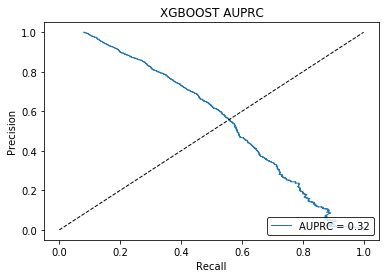

In [86]:
fpr, tpr, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
auprc = average_precision_score(y_test, predict)

plt.plot(fpr, tpr, lw=1, label='AUPRC = %0.2f'%(auprc))
plt.plot([0, 1], [0, 1], '--k', lw=1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBOOST AUPRC')
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')

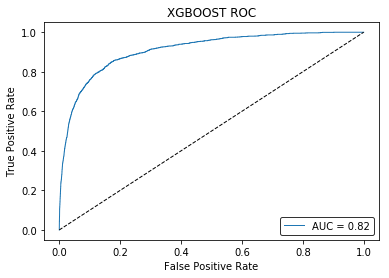

In [87]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test, predict)

plt.plot(fpr, tpr, lw=1, label='AUC = %0.2f'%(roc_auc))
plt.plot([0, 1], [0, 1], '--k', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBOOST ROC')
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')

In [88]:
feature_name=X.columns.tolist()
#feature_name.remove('DevType_Data scientist or machine learning specialist')
dtrain = xgb.DMatrix(X, label=y,feature_names=feature_name)

In [89]:
# model.get_booster().get_score().items()

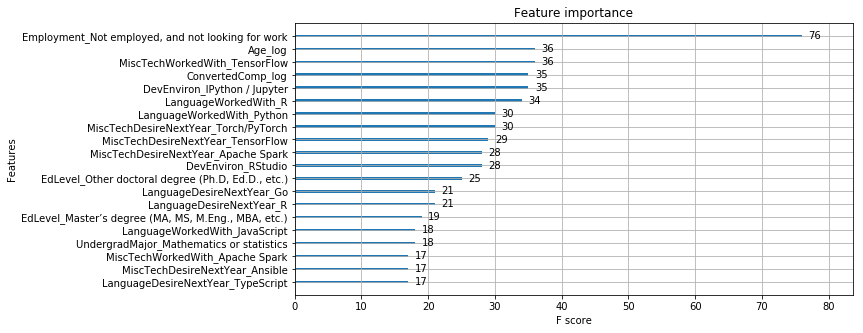

In [90]:
# mapper = {'f{0}'.format(i): v for i, v in enumerate(dtrain.feature_names)}
# mapped = { mapper[k]: v for k, v in model.get_booster().get_score().items()}

fig,ax  =  plt.subplots (figsize=(10, 5))
xgb.plot_importance(model, max_num_features=20,ax=ax)
plt.show()

In [91]:

df.groupby(['Employment_Not employed, and not looking for work', 'DevType_Data scientist or machine learning specialist']).size()


Employment_Not employed, and not looking for work  DevType_Data scientist or machine learning specialist
0                                                  0                                                        78620
                                                   1                                                         6460
1                                                  0                                                         3803
dtype: int64

The classifier does not return a clear bountary between data scientist and non data scientist. I am interested if we remove the mixed data scientist from the training and test data, will the model perform better? Let's do it.

In [92]:
# Retrieve the character variables.
# df = survey_2019[survey_2019['Country']=='United States']
df = pd.concat([pure_data_scientist,non_data_scientist])
cat_vars_int = df.select_dtypes(include=['object']).copy().columns
len(cat_vars_int)
df.shape

(82949, 85)

In [93]:
# Again split and transpose the categorical variable into one-hot columns.
for var in  cat_vars_int:
    # for each cat add dummy var, drop original column
    df = pd.concat([df.drop(var, axis=1), df[var].str.get_dummies(sep=';').rename(lambda x: var+'_' + x, axis='columns')], axis=1)

df.describe()

Respondent     CompTotal  ConvertedComp   WorkWeekHrs    CodeRevHrs  \
count  82949.000000  5.211300e+04   5.200100e+04  60069.000000  46569.000000   
mean   44469.094383  4.005932e+11   1.263714e+05     42.097826      5.067477   
std    25675.540577  6.206637e+13   2.824900e+05     38.138955      5.395837   
min        1.000000  0.000000e+00   0.000000e+00      1.000000      0.000000   
25%    22199.000000  2.000000e+04   2.566800e+04     40.000000      2.000000   
50%    44495.000000  6.100000e+04   5.707200e+04     40.000000      4.000000   
75%    66712.000000  1.200000e+05   1.000000e+05     44.000000      6.000000   
max    88883.000000  1.000000e+16   2.000000e+06   4850.000000     99.000000   

                Age  MainBranch_I am a developer by profession  \
count  73914.000000                               82949.000000   
mean      30.325466                                   0.743770   
std        9.211656                                   0.436553   
min        1.000000                                   0.000000   
25%       24.000000                                   0.000000   
50%       29.000000                                   1.000000   
75%       35.000000                                   1.000000   
max       99.000000                                   1.000000   

       MainBranch_I am a student who is learning to code  \
count                                       82949.000000   
mean                                            0.115396   
std                                             0.319501   
min                                             0.000000   
25%                                             0.000000   
50%                                             0.000000   
75%                                             0.000000   
max                                             1.000000   

       MainBranch_I am not primarily a developer, but I write code sometimes as part of my work  \
count                                                                              82949.000000   
mean                                                                                   0.077698   
std                                                                                    0.267698   
min                                                                                    0.000000   
25%                                                                                    0.000000   
50%                                                                                    0.000000   
75%                                                                                    0.000000   
max                                                                                    1.000000   

       MainBranch_I code primarily as a hobby  \
count                            82949.000000   
mean                                 0.038940   
std                                  0.193452   
min                                  0.000000   
25%                                  0.000000   
50%                                  0.000000   
75%                                  0.000000   
max                                  1.000000   

       MainBranch_I used to be a developer by profession, but no longer am  \
count                                                         82949.000000   
mean                                                              0.017891   
std                                                               0.132554   
min                                                               0.000000   
25%                                                               0.000000   
50%                                                               0.000000   
75%                                                               0.000000   
max                                                               1.000000   

        Hobbyist_No  Hobbyist_Yes  \
count  82949.000000  82949.000000   
mean       0.201413      0.798587   
std 

In [94]:
df.shape

(82949, 1177)

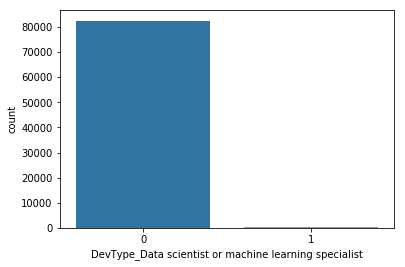

In [95]:
sns.countplot(df['DevType_Data scientist or machine learning specialist'])

In [96]:
np.sum(df['DevType_Data scientist or machine learning specialist'])

526

In [97]:
# Impute missing values with column median
df['CodeRevHrs'] = df['CodeRevHrs'].fillna(df['CodeRevHrs'].median())
df['Age'] = df['Age'].fillna(df['Age'].median())
df['WorkWeekHrs'] = df['WorkWeekHrs'].fillna(df['WorkWeekHrs'].median())
df['ConvertedComp'] = df['ConvertedComp'].fillna(df['ConvertedComp'].median())

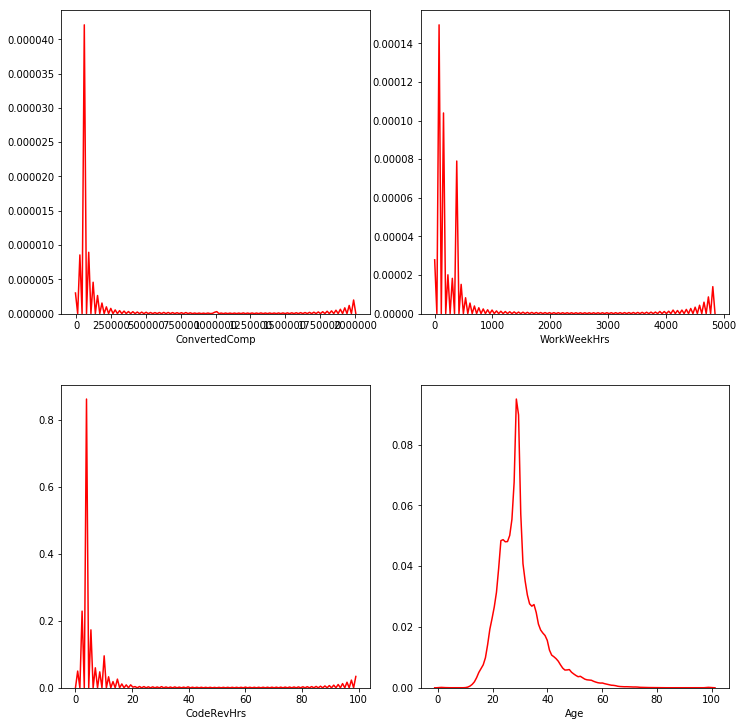

In [98]:
# See if the numeric variables need to be normalized.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
plt.tight_layout(w_pad=2.0, h_pad=5.0)

plt.subplot(2,2,1)
plt.xlabel('ConvertedComp')
p1 = sns.distplot(df[['ConvertedComp']], hist=False,color='red',norm_hist=True)

plt.subplot(2,2,2)
plt.xlabel('WorkWeekHrs')
p2 = sns.distplot(df[['WorkWeekHrs']], hist=False,color='red',norm_hist=True)

plt.subplot(2,2,3)
plt.xlabel('CodeRevHrs')
p3 = sns.distplot(df[['CodeRevHrs']], hist=False,color='red',norm_hist=True)

plt.subplot(2,2,4)
plt.xlabel('Age')
p4 = sns.distplot(df[['Age']], hist=False,color='red',norm_hist=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


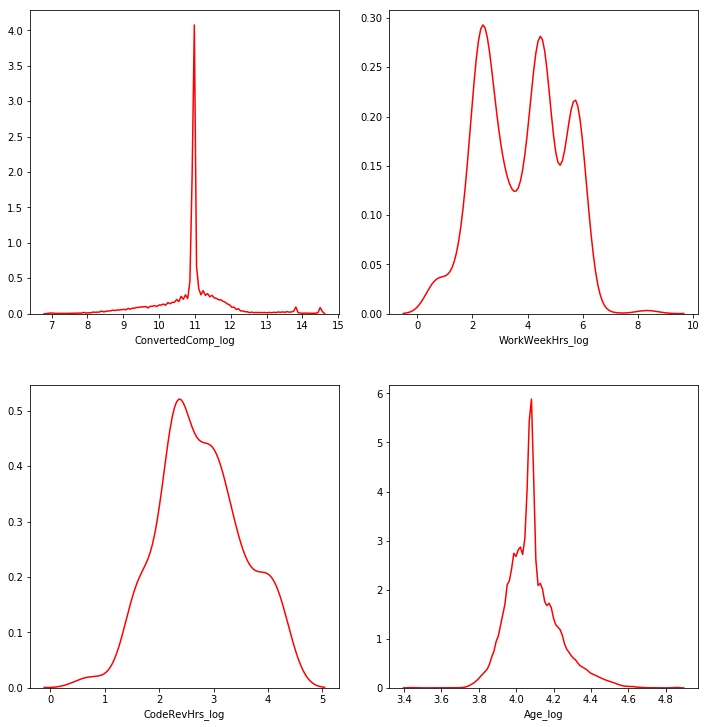

In [99]:
# Use logarithm function to transform the numeric columns
df['ConvertedComp_log'] = np.log(df['ConvertedComp']+1000)
df['WorkWeekHrs_log'] = np.log(df['WorkWeekHrs']-70)
df['CodeRevHrs_log'] = np.log(df['CodeRevHrs']-30)
df['Age_log'] = np.log(df['Age']+30)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
plt.tight_layout(w_pad=2.0, h_pad=5.0)

plt.subplot(2,2,1)
plt.xlabel('ConvertedComp_log')
p1 = sns.distplot(df[['ConvertedComp_log']], hist=False,color='red',norm_hist=True)

plt.subplot(2,2,2)
plt.xlabel('WorkWeekHrs_log')
p2 = sns.distplot(df[['WorkWeekHrs_log']], hist=False,color='red',norm_hist=True)

plt.subplot(2,2,3)
plt.xlabel('CodeRevHrs_log')
p3 = sns.distplot(df[['CodeRevHrs_log']], hist=False,color='red',norm_hist=True)

plt.subplot(2,2,4)
plt.xlabel('Age_log')
p4 = sns.distplot(df[['Age_log']], hist=False,color='red',norm_hist=True)

In [100]:
# Split data set into response vector and feature matrix.
y = df['DevType_Data scientist or machine learning specialist'].values
X = df.drop(['DevType_Data scientist or machine learning specialist'], axis=1)

In [101]:
X = X.drop(['Respondent','CompTotal'],axis=1)
X = X.drop([col for col in X.columns if 'DevType_' in col],axis=1)
X = X.drop(['CodeRevHrs','ConvertedComp','WorkWeekHrs','Age'],axis=1)
X.shape

(82949, 1151)

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0,stratify=y)

In [103]:
model = xgb.XGBClassifier(
    learning_rate =0.01, n_estimators=1000,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic', 
    nthread=4,
    scale_pos_weight=100,
    seed=27,
    max_depth = 5,
    min_child_weight = 3
)

def evalauc(preds, dtrain):
    labels = dtrain.get_label()
    precision, recall, thresholds = precision_recall_curve(labels, preds)
    area = auc(recall, precision)
    return 'AUPRC', -area


model.fit(X_train, y_train,
          eval_metric=evalauc,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          early_stopping_rounds=5,
         verbose=True)

[0]	validation_0-error:0.066982	validation_1-error:0.071656	validation_0-AUPRC:-0.215324	validation_1-AUPRC:-0.283491
Multiple eval metrics have been passed: 'validation_1-AUPRC' will be used for early stopping.

Will train until validation_1-AUPRC hasn't improved in 5 rounds.
[1]	validation_0-error:0.050779	validation_1-error:0.054972	validation_0-AUPRC:-0.293979	validation_1-AUPRC:-0.281928
[2]	validation_0-error:0.063542	validation_1-error:0.068184	validation_0-AUPRC:-0.34368	validation_1-AUPRC:-0.327119
[3]	validation_0-error:0.055424	validation_1-error:0.058154	validation_0-AUPRC:-0.36222	validation_1-AUPRC:-0.335526
[4]	validation_0-error:0.05917	validation_1-error:0.063989	validation_0-AUPRC:-0.369002	validation_1-AUPRC:-0.331828
[5]	validation_0-error:0.059957	validation_1-error:0.063603	validation_0-AUPRC:-0.372946	validation_1-AUPRC:-0.323059
[6]	validation_0-error:0.060038	validation_1-error:0.06341	validation_0-AUPRC:-0.362987	validation_1-AUPRC:-0.327499
[7]	validation_0-e

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=100, seed=27,
              silent=None, subsample=0.8, verbosity=1)

In [104]:
# See the prediction result
predict = model.predict(X_test)
print(classification_report(y_test, predict))
print(confusion_matrix(y_test,predict))
print("Accuracy: ")
print(accuracy_score(y_test,predict))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     20606
           1       0.09      0.86      0.16       132

    accuracy                           0.94     20738
   macro avg       0.54      0.90      0.56     20738
weighted avg       0.99      0.94      0.96     20738

[[19418  1188]
 [   18   114]]
Accuracy: 
0.9418458867778956


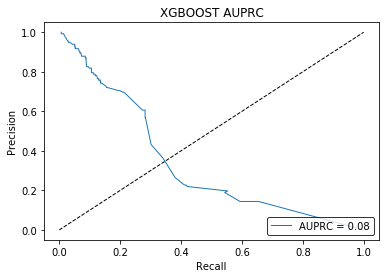

In [105]:
fpr, tpr, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
auprc = average_precision_score(y_test, predict)

plt.plot(fpr, tpr, lw=1, label='AUPRC = %0.2f'%(auprc))
plt.plot([0, 1], [0, 1], '--k', lw=1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBOOST AUPRC')
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')

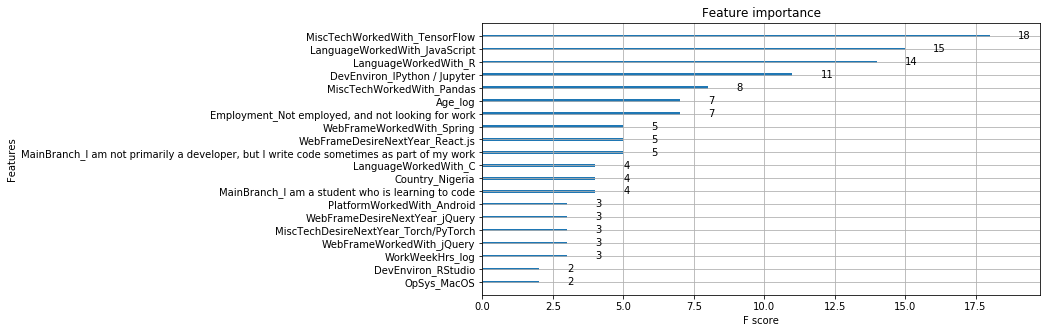

In [106]:
fig,ax  =  plt.subplots (figsize=(10, 5))
xgb.plot_importance(model, max_num_features=20,ax=ax)
plt.show()

In [107]:
df.groupby(['DevType_Data scientist or machine learning specialist','MiscTechWorkedWith_TensorFlow']).size()

DevType_Data scientist or machine learning specialist  MiscTechWorkedWith_TensorFlow
0                                                      0                                78813
                                                       1                                 3610
1                                                      0                                  276
                                                       1                                  250
dtype: int64

Still, the model is not as good as I anticipate, there are many other developers being classified as data scientist. We can see somehow the top important feature is TensorFlow known by almost 50% of pure data scientist, while part of the non data scientist also know. The most distinct feature seems not to distinguish a data scientist very well. 